<div style="display: flex; align-items: center;">
    <h1 style="font-size: 3em; margin-right: 15px;">
        Physics Aware Recurrent Convolutional Neural Network (PARC): ShearFlow Equation Demo
    </h1>
    <div>
        <img src="../misc/VIL_logo.png" width="120" alt="Image 1" style="margin-right: 5px;" />
        <img src="../misc/uva.png" width="120" alt="Image 2" style="margin-right: 5px;" />
        <img src="../misc/iowa.png" width="120" alt="Image 3" />
    </div>
</div>

<p>
A customizable framework to embed physics in Deep Learning.
PARC's formulation is inspired by Advection-Diffusion-Reaction processes and uses an Inductive Bias approach to constrain the Neural Network.
</p>


# Modeling Shear Flow with PARC

This notebook aims to simulate the 2D periodic shear flow dynamics, a simplified version of the Navier-Stokes equation in a condition that it is incompressible (without consideration for pressure). A shear flow is a type of fluid that contains layers sliding past each other at varying velocities.

The notebook will guide you through from start to finish in preparing, training, and modeling the physics-based equation's prediction results. The notebook primarily covers three sections:
- loading and preparing the data for the Shear Flow's Equation
- Using the PARC Model to learn and predict the time evolution of velocity fields $u$ and tracer distributions $s$
- Evaluating the model's performance and compare predicted results to ground truth

# What exactly is a Shear Flow?

Shear Flows can be observed in many real life scenarios. For example, the air closest to an airplane's wings moves slower due to friction, while the air further way moves faster. This velocity difference in turn creates a shear flow and is critical for generating lift power for the plane. In a natural setting such as in rivers, water moves slower at the surface and faster at the river bed. The veloctiy gradient again creates 'stress' on the bed surface and thereby causes phenomenons like erotion or transportation of sediments.

Mathmatically, its primary equations governing the Shear Flow simulations are:

$$\frac{\partial u}{\partial t} + \nabla p - \nu \Delta u = -u\cdot \nabla u,$$

$$\frac{\partial s}{\partial t} - D\Delta s = -u \cdot \nabla s$$

In the first equation:
- $u$ is the velocity of the fluid 
- $\frac{\partial u}{\partial t}$ is the changes of velocity over time
- $\nabla p$ is the effect of pressure pushing the fluid around
- $\nu \Delta u$ describes the internal friction (viscosity) that resist fluid motion (**note:** $\nu$ stands for viscosity, $\Delta = \nabla \cdot \nabla$ it measures how 'curvy' something is, like a second-derivative that tells you whether you are at a global/local maximum, minimum, or a saddle point)
- $-u\cdot \nabla u$ describes the advection, meaning how a fluid that is already is motion is carrying itself along 

To sum up, this describes how changes in motion is equivalent to forces applied to the fluid due to **pressure** + **friction** - the fluid advection

In the second equation:
- $u$ again is the velocity vector of the fluid
- $s$ is the **flow tracer**, you can think of it as any substance/fluid property being carried by the fluid and is used to track flow velocity. (i.e. temperature, salinity, or dyes and small particles)
- $\frac{\partial s}{\partial t}$ describes how the tracer changes over time
- $-D\Delta s$ describes te natural diffusion/spreading of the tracer (I.e. how fast a substance spreads in water) (**note:** D stands for diffusivity, which measures how easily tracers spread)
- $-u\cdot \nabla s$ describes the rate of decrease of the tracer $s$ in the direction of the flow

This overall means that changes in tracer concentration equals how the tracer spreads out - how the tracer is moved around by the fluid

The two PDEs are **parameterized** by the Reynolds & Schmidt through $\nu$ and $D$ in the form of:

- **Viscosity**:
$$\nu = \frac{1}{Reynolds}$$
- **Diffusivity**:
$$D = \frac{\nu}{Schmidt}$$

# Goals of PARC for Shear Flow 

In this notebook we aim to use the PARC Neural Network to predict future **velocity fields $u$** and **tracer distributions $s$** based on current states. The neural network will be estimating the hidden physical parameters like $\nu$ and $D$ from the given observed Shear Flow data. This is essential as the neural network could learn not just the solutions to the predicted outcome of the shear flow at a future state, but also learning how the outcome changes/varies with different parameter values of **Viscosity** and **Diffusivity**




# Setting Up

This document serves as a guide to training a PARC model for the Shear Flow equation. Here are the initial steps to take before you begin training your PARC model!

Download & Prepare Data:
- Extract the downloaded data and ensure that it is placed in the following directory: `PARCtorch/PARCtorch/data`
- Make sure that the file paths at `train_dir` and `test_dir` point to the correct paths to your training and testing data, e.g. `../data/train` or `../data/test`

Install PARCtorch:
- Ensure PARCtorch is installed in your Python Environment, you could view the installation instructions [here](https://github.com/baeklab/PARCtorch/tree/main#installation)
- After the installation, install all the relevant dependencies with `!pip install -r requirements.txt` (The versions of your dependencies need to be <b>consistent</b> with our requirements, or else the script might not run!)
- Optional (only if the script doesn't run): add the root directory to the system's path so that it runs

In [1]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Compute Data Normalization


In [2]:
from pathlib import Path

from PARCtorch.data.normalization import compute_min_max

In [3]:
# Define data directories
train_dir = Path("/standard/sds_baek_energetic/data/physics/the_well/datasets/shear_flow/data/train")
test_dir = Path("/standard/sds_baek_energetic/data/physics/the_well/datasets/shear_flow/data/test")

# Load Training Data

In [4]:
import logging
import torch
from torch.utils.data import DataLoader

from PARCtorch.data.dataset import (
    WellDatasetInterface,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from PARCtorch.utilities.viz import (
    visualize_channels,
    save_gifs_with_ground_truth,
)

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

future_steps = 1
# Path to the min_max.json file
batch_size = 2

train_dataset = WellDatasetInterface(
    well_dataset_args={
        "well_base_path": "/standard/sds_baek_energetic/data/physics/the_well/datasets",
        "well_dataset_name": "shear_flow",
        "well_split_name": "train",
        "exclude_filters": ["shear_flow_Reynolds_5e5_Schmidt_1e0.hdf5"]
    },
    future_steps=future_steps
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    collate_fn=custom_collate_fn,
)

# Visualizing the Data - Sanity-Check

In [5]:
channel_names = (
    train_dataset.well_dataset.field_names[1] + 
    train_dataset.well_dataset.field_names[0]
)
print(channel_names)
print(train_dataset.well_dataset.field_names)


['velocity_x', 'velocity_y', 'tracer', 'pressure']
{0: ['tracer', 'pressure'], 1: ['velocity_x', 'velocity_y'], 2: []}


WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
Channel Data Statistics:
Channel 0: IC min=10000.0, IC max=10000.0
  Step 1: min=10000.0, max=10000.0
Channel 1: IC min=0.10000000149011612, IC max=0.10000000149011612
  Step 1: min=0.10000000149011612, max=0.10000000149011612
Channel 2: IC min=-0.5, IC max=0.5
  Step 1: min=-0.5, max=0.5
Channel 3: IC min=0.0, IC max=0.0
  Step 1: min=-0.02280947007238865

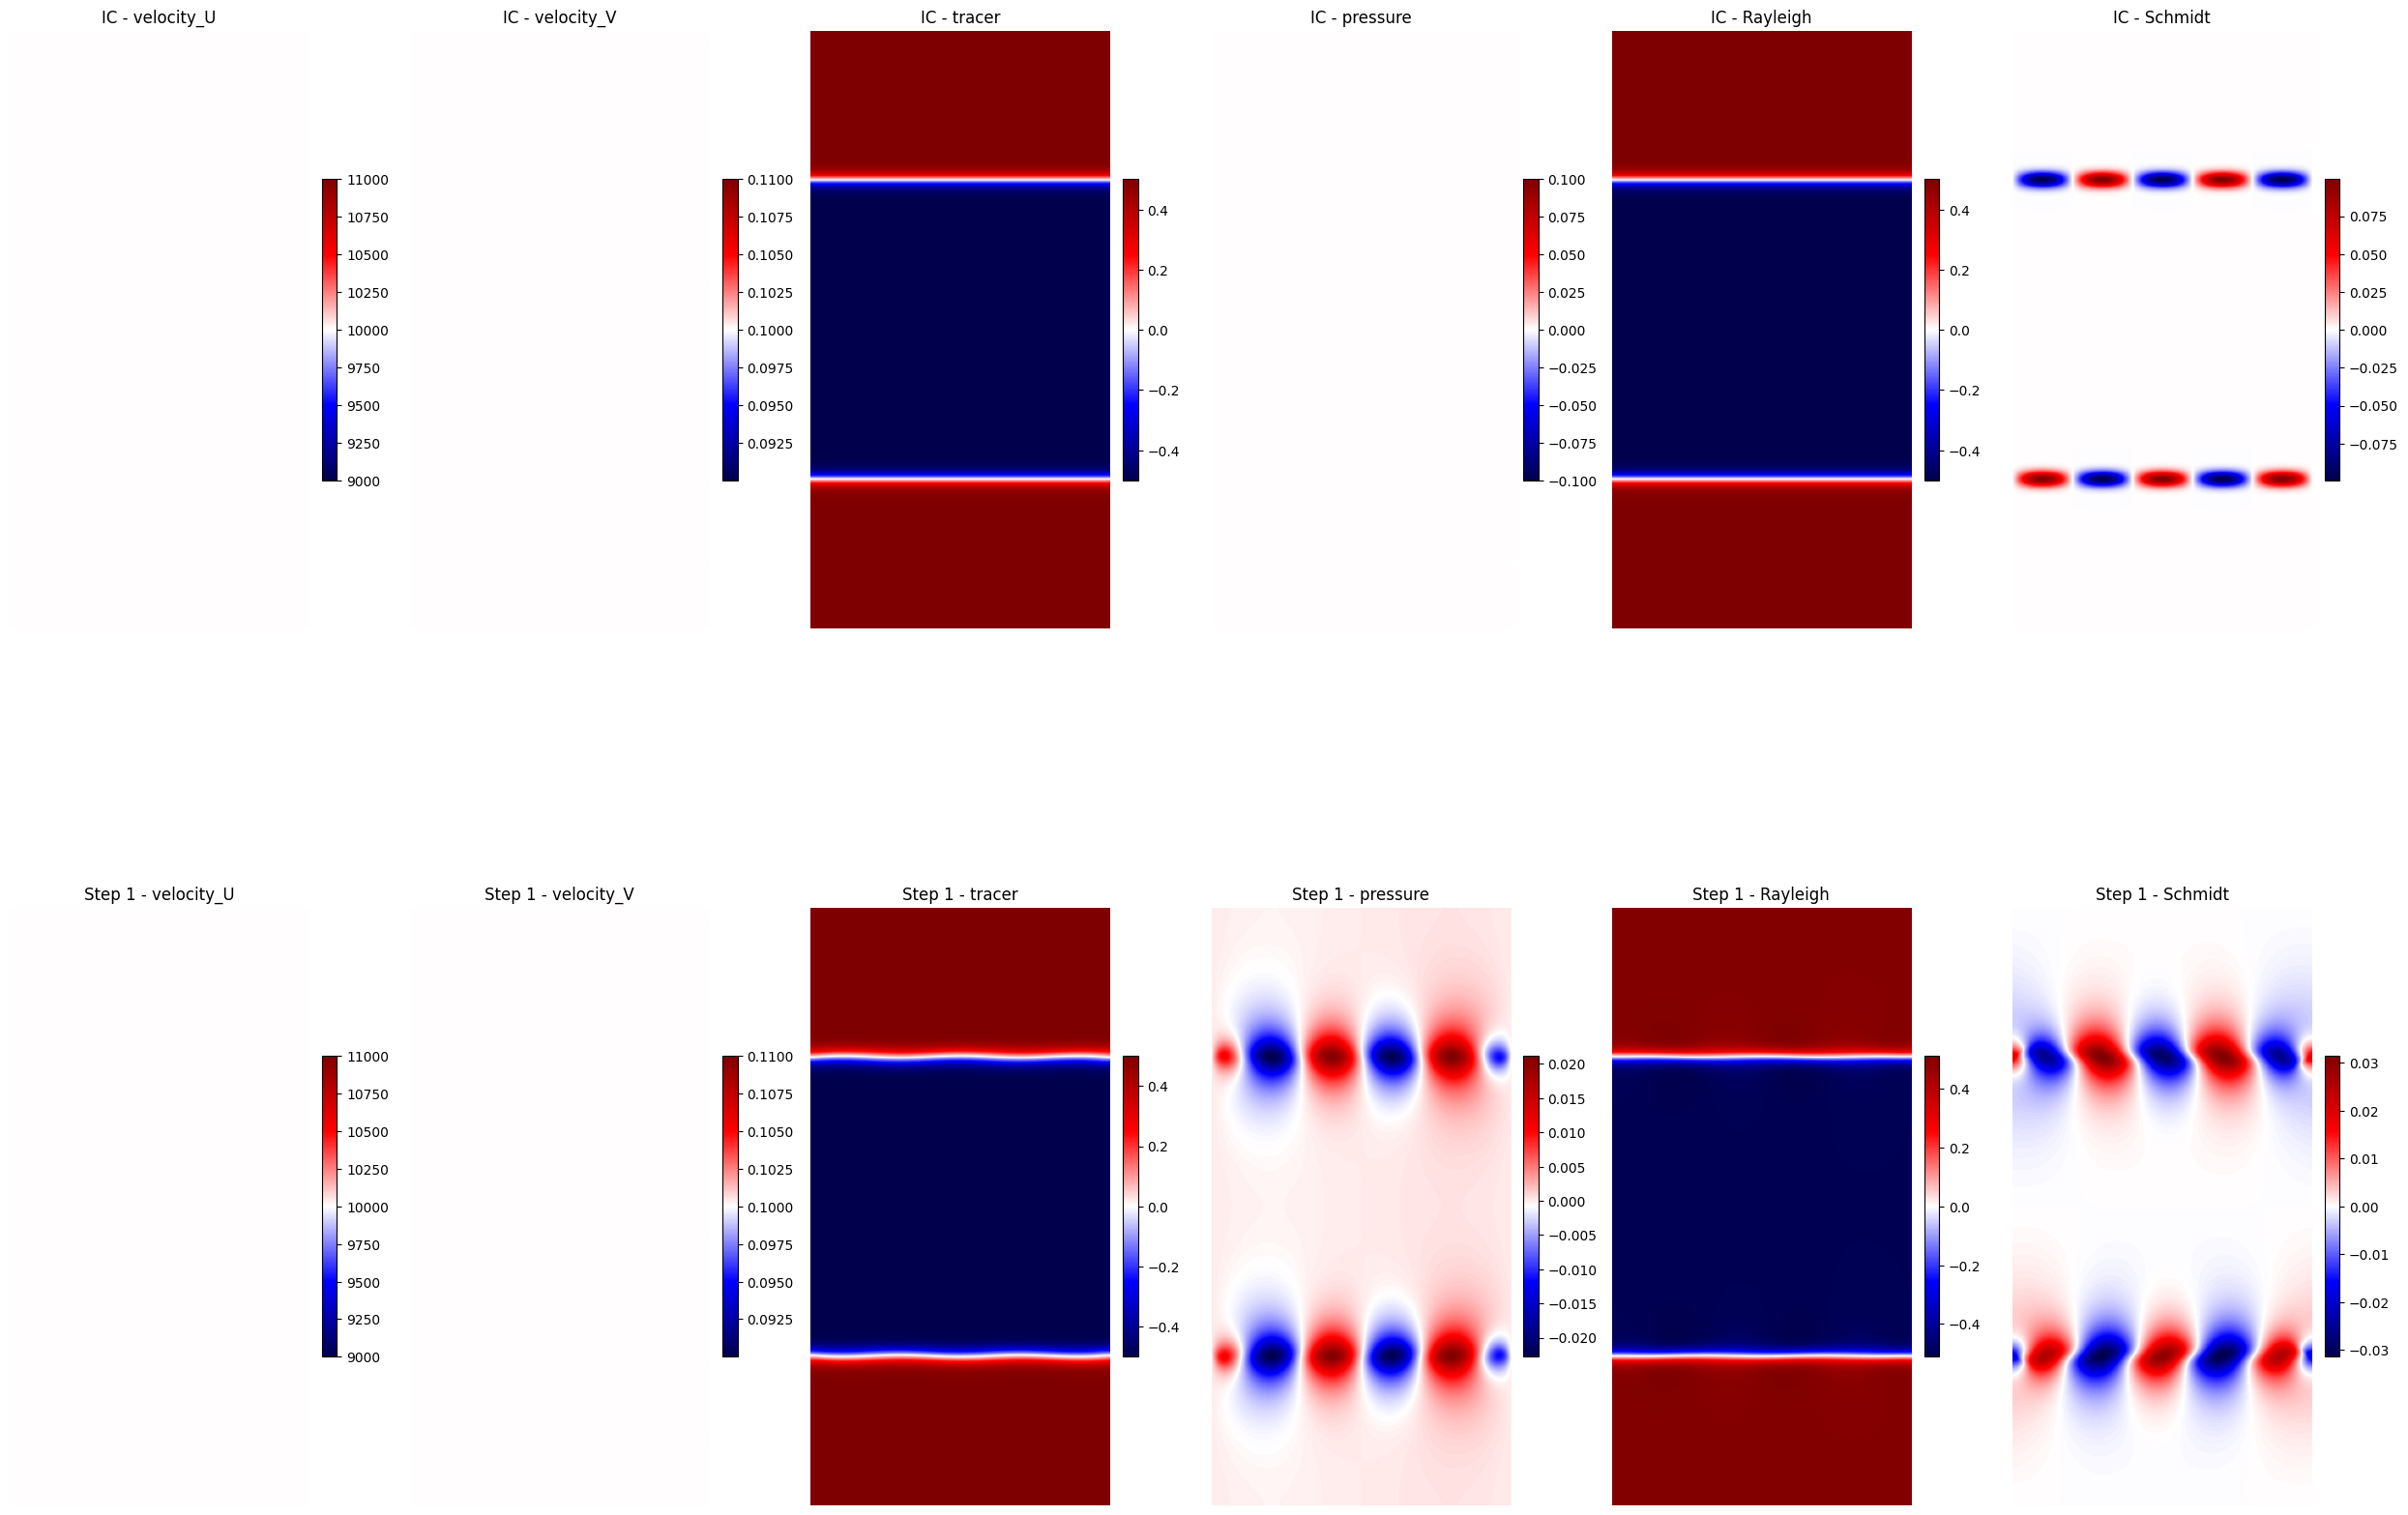

In [6]:
for batch_idx, batch in enumerate(train_loader):
    ic, t0, t1, target = batch
    channel_names = ['velocity_U', 
                     'velocity_V', 
                     'tracer', 
                     'pressure',
                     'Rayleigh',
                     'Schmidt',
                    ]
    custom_cmaps = ["seismic"] * 6

    visualize_channels(
        ic = ic,      
        t0 = t0,
        t1 = t1,
        target = target,      
        channel_names = channel_names,
        channel_cmaps = custom_cmaps,
    )
    break

# Building the PARC Model

In [7]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import ADRDifferentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

from torch.optim import Adam

n_fe_features = 16
unet_ShearFlow = UNet(
    block_dimensions=[64, 64 * 2, 64 * 4],        
    input_channels=6,                             
    output_channels=n_fe_features,                
    kernel_size=3,                                
    padding_mode="zeros",                         
    up_block_use_concat=[False, True],            
    skip_connection_indices=[0],                  
)
right_diff = FiniteDifference(padding_mode="replicate").cuda()
heun_int = Heun().cuda()

diff_ShearFlow = ADRDifferentiator(
    n_state_var=4,                          
    n_fe_features=n_fe_features,            
    list_adv_idx=[0,1, 2, 3, 4, 5],                    
    list_dif_idx=[0, 1, 2, 3, 4, 5],                   
    feature_extraction=unet_ShearFlow,       
    padding_mode="constant",               
    finite_difference_method=right_diff,    
    spade_random_noise=False,               
).cuda()


ShearFlow_int = Integrator(
    clip=True,                             
    list_poi_idx=[],                       
    num_int=heun_int,                      
    list_dd_int=[None, None, None, None],       
    padding_mode="constant",              
    finite_difference_method=right_diff,  
    poi_kernel_size=3,                     
    n_poi_features=64                      
)
criterion = torch.nn.L1Loss().cuda()


model = PARCv2(
    differentiator=diff_ShearFlow,  
    integrator=ShearFlow_int,       
    loss=criterion                
).cuda()
optimizer = Adam(
    params=model.parameters(), 
    lr=1e-5             
)
    

# Training the Model

In [ ]:
from train import train_model
save_dirs = Path("/home/wkt7ne/PARCtorch/PARCtorch/demos/results/SF_model_weights")
save_dirs.mkdir(exist_ok=True, parents=True)

train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=10,
    save_dir=save_dirs,
    app='ns',
)

Epoch 1/1:   0%|          | 0/70048 [00:00<?, ?it/s]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 1/70048 [00:06<124:29:14,  6.40s/it, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 2/70048 [00:06<54:26:31,  2.80s/it, Batch Loss=2e+3] 

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 3/70048 [00:07<32:47:03,  1.68s/it, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 4/70048 [00:07<21:58:33,  1.13s/it, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 5/70048 [00:07<16:02:15,  1.21it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 6/70048 [00:07<12:25:30,  1.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 7/70048 [00:08<10:10:38,  1.91it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 8/70048 [00:08<8:39:33,  2.25it/s, Batch Loss=2e+3] 

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 9/70048 [00:08<7:40:26,  2.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 10/70048 [00:08<6:58:20,  2.79it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 11/70048 [00:09<6:31:21,  2.98it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 12/70048 [00:09<6:10:50,  3.15it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 13/70048 [00:09<5:58:30,  3.26it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 14/70048 [00:10<5:48:06,  3.35it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 15/70048 [00:10<5:48:08,  3.35it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 16/70048 [00:10<5:40:59,  3.42it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 17/70048 [00:10<5:37:46,  3.46it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 18/70048 [00:11<5:33:37,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 19/70048 [00:11<5:32:30,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 20/70048 [00:11<5:29:57,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 21/70048 [00:12<5:30:02,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 22/70048 [00:12<5:28:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 23/70048 [00:12<5:28:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 24/70048 [00:12<5:28:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 25/70048 [00:13<5:28:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 26/70048 [00:13<5:27:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 27/70048 [00:13<5:28:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 28/70048 [00:14<5:26:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 29/70048 [00:14<5:27:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 30/70048 [00:14<5:26:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 31/70048 [00:14<5:28:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 32/70048 [00:15<5:27:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 33/70048 [00:15<5:28:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 34/70048 [00:15<5:26:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 35/70048 [00:16<5:27:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 36/70048 [00:16<5:26:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 37/70048 [00:16<5:28:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 38/70048 [00:16<5:27:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 39/70048 [00:17<5:28:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 40/70048 [00:17<5:26:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 41/70048 [00:17<5:27:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 42/70048 [00:17<5:27:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 43/70048 [00:18<5:28:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 44/70048 [00:18<5:27:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 45/70048 [00:18<5:28:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 46/70048 [00:19<5:26:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 47/70048 [00:19<5:27:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 48/70048 [00:19<5:26:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 49/70048 [00:19<5:27:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 50/70048 [00:20<5:26:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 51/70048 [00:20<5:30:40,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 52/70048 [00:20<5:28:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 53/70048 [00:21<5:29:12,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 54/70048 [00:21<5:27:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 55/70048 [00:21<5:28:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 56/70048 [00:21<5:27:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 57/70048 [00:22<5:27:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 58/70048 [00:22<5:26:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 59/70048 [00:22<5:27:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 60/70048 [00:23<5:26:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 61/70048 [00:23<5:27:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 62/70048 [00:23<5:26:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 63/70048 [00:23<5:27:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 64/70048 [00:24<5:26:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 65/70048 [00:24<5:27:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 66/70048 [00:24<5:26:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 67/70048 [00:25<5:27:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 68/70048 [00:25<5:26:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 69/70048 [00:25<5:27:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 70/70048 [00:25<5:26:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 71/70048 [00:26<5:27:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 72/70048 [00:26<5:26:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 73/70048 [00:26<5:27:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 74/70048 [00:26<5:26:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 75/70048 [00:27<5:27:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 76/70048 [00:27<5:26:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 77/70048 [00:27<5:27:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 78/70048 [00:28<5:27:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 79/70048 [00:28<5:28:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 80/70048 [00:28<5:26:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 81/70048 [00:28<5:27:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 82/70048 [00:29<5:26:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 83/70048 [00:29<5:27:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 84/70048 [00:29<5:26:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 85/70048 [00:30<5:27:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 86/70048 [00:30<5:26:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 87/70048 [00:30<5:27:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 88/70048 [00:30<5:26:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 89/70048 [00:31<5:27:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 90/70048 [00:31<5:26:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 91/70048 [00:31<5:27:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 92/70048 [00:32<5:26:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 93/70048 [00:32<5:28:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 94/70048 [00:32<5:26:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 95/70048 [00:32<5:27:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 96/70048 [00:33<5:31:18,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 97/70048 [00:33<5:30:51,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 98/70048 [00:33<5:29:06,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 99/70048 [00:34<5:29:27,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 100/70048 [00:34<5:27:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 101/70048 [00:34<5:28:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 102/70048 [00:34<5:27:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 103/70048 [00:35<5:28:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 104/70048 [00:35<5:27:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 105/70048 [00:35<5:27:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 106/70048 [00:35<5:26:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 107/70048 [00:36<5:27:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 108/70048 [00:36<5:26:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 109/70048 [00:36<5:27:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 110/70048 [00:37<5:26:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 111/70048 [00:37<5:27:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 112/70048 [00:37<5:26:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 113/70048 [00:37<5:29:30,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 114/70048 [00:38<5:27:52,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 115/70048 [00:38<5:28:49,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 116/70048 [00:38<5:27:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 117/70048 [00:39<5:28:40,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 118/70048 [00:39<5:27:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 119/70048 [00:39<5:28:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 120/70048 [00:39<5:27:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 121/70048 [00:40<5:28:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 122/70048 [00:40<5:27:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 123/70048 [00:40<5:28:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 124/70048 [00:41<5:26:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 125/70048 [00:41<5:28:00,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 126/70048 [00:41<5:32:59,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 127/70048 [00:41<5:32:52,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 128/70048 [00:42<5:30:27,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 129/70048 [00:42<5:30:33,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 130/70048 [00:42<5:28:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 131/70048 [00:43<5:29:09,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 132/70048 [00:43<5:27:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 133/70048 [00:43<5:28:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 134/70048 [00:43<5:27:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 135/70048 [00:44<5:28:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 136/70048 [00:44<5:26:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 137/70048 [00:44<5:27:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 138/70048 [00:44<5:26:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 139/70048 [00:45<5:28:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 140/70048 [00:45<5:27:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 141/70048 [00:45<5:28:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 142/70048 [00:46<5:27:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 143/70048 [00:46<5:28:41,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 144/70048 [00:46<5:27:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 145/70048 [00:46<5:28:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 146/70048 [00:47<5:27:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 147/70048 [00:47<5:28:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 148/70048 [00:47<5:27:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 149/70048 [00:48<5:28:42,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 150/70048 [00:48<5:28:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 151/70048 [00:48<5:29:19,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 152/70048 [00:48<5:29:01,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 153/70048 [00:49<5:29:52,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 154/70048 [00:49<5:29:02,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 155/70048 [00:49<5:29:42,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 156/70048 [00:50<5:28:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 157/70048 [00:50<5:28:57,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 158/70048 [00:50<5:27:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 159/70048 [00:50<5:29:05,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 160/70048 [00:51<5:27:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 161/70048 [00:51<5:28:55,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 162/70048 [00:51<5:27:48,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 163/70048 [00:52<5:28:44,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 164/70048 [00:52<5:27:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 165/70048 [00:52<5:28:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 166/70048 [00:52<5:27:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 167/70048 [00:53<5:28:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 168/70048 [00:53<5:26:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 169/70048 [00:53<5:28:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 170/70048 [00:54<5:26:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 171/70048 [00:54<5:28:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 172/70048 [00:54<5:27:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 173/70048 [00:54<5:28:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 174/70048 [00:55<5:26:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 175/70048 [00:55<5:27:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 176/70048 [00:55<5:27:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 177/70048 [00:55<5:29:45,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 178/70048 [00:56<5:28:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 179/70048 [00:56<5:28:57,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 180/70048 [00:56<5:27:59,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 181/70048 [00:57<5:28:47,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 182/70048 [00:57<5:27:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 183/70048 [00:57<5:28:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 184/70048 [00:57<5:26:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 185/70048 [00:58<5:27:52,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 186/70048 [00:58<5:26:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 187/70048 [00:58<5:27:37,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 188/70048 [00:59<5:27:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 189/70048 [00:59<5:28:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 190/70048 [00:59<5:27:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 191/70048 [00:59<5:28:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 192/70048 [01:00<5:27:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 193/70048 [01:00<5:27:56,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 194/70048 [01:00<5:26:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 195/70048 [01:01<5:28:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 196/70048 [01:01<5:26:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 197/70048 [01:01<5:27:40,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 198/70048 [01:01<5:26:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 199/70048 [01:02<5:27:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 200/70048 [01:02<5:26:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 201/70048 [01:02<5:27:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 202/70048 [01:03<5:26:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 203/70048 [01:03<5:27:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 204/70048 [01:03<5:26:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 205/70048 [01:03<5:27:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 206/70048 [01:04<5:26:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 207/70048 [01:04<5:27:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 208/70048 [01:04<5:26:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 209/70048 [01:04<5:27:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 210/70048 [01:05<5:27:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 211/70048 [01:05<5:28:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 212/70048 [01:05<5:26:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 213/70048 [01:06<5:27:40,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 214/70048 [01:06<5:26:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 215/70048 [01:06<5:27:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 216/70048 [01:06<5:26:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 217/70048 [01:07<5:27:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 218/70048 [01:07<5:26:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 219/70048 [01:07<5:27:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 220/70048 [01:08<5:26:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 221/70048 [01:08<5:27:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 222/70048 [01:08<5:25:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 223/70048 [01:08<5:26:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 224/70048 [01:09<5:25:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 225/70048 [01:09<5:27:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 226/70048 [01:09<5:25:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 227/70048 [01:10<5:27:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 228/70048 [01:10<5:25:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 229/70048 [01:10<5:26:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 230/70048 [01:10<5:25:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 231/70048 [01:11<5:27:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 232/70048 [01:11<5:26:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 233/70048 [01:11<5:27:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 234/70048 [01:11<5:25:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 235/70048 [01:12<5:26:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 236/70048 [01:12<5:25:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 237/70048 [01:12<5:26:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 238/70048 [01:13<5:25:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 239/70048 [01:13<5:26:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 240/70048 [01:13<5:25:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 241/70048 [01:13<5:26:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 242/70048 [01:14<5:25:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 243/70048 [01:14<5:26:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 244/70048 [01:14<5:27:21,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 245/70048 [01:15<5:27:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 246/70048 [01:15<5:26:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 247/70048 [01:15<5:27:38,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 248/70048 [01:15<5:26:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 249/70048 [01:16<5:27:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 250/70048 [01:16<5:26:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 251/70048 [01:16<5:27:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 252/70048 [01:17<5:25:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 253/70048 [01:17<5:27:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 254/70048 [01:17<5:25:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 255/70048 [01:17<5:27:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 256/70048 [01:18<5:25:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 257/70048 [01:18<5:26:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 258/70048 [01:18<5:25:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 259/70048 [01:19<5:27:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 260/70048 [01:19<5:25:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 261/70048 [01:19<5:27:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 262/70048 [01:19<5:26:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 263/70048 [01:20<5:27:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 264/70048 [01:20<5:25:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 265/70048 [01:20<5:26:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 266/70048 [01:20<5:25:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 267/70048 [01:21<5:26:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 268/70048 [01:21<5:25:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 269/70048 [01:21<5:26:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 270/70048 [01:22<5:25:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 271/70048 [01:22<5:26:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 272/70048 [01:22<5:25:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 273/70048 [01:22<5:26:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 274/70048 [01:23<5:25:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 275/70048 [01:23<5:26:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 276/70048 [01:23<5:25:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 277/70048 [01:24<5:26:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 278/70048 [01:24<5:25:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 279/70048 [01:24<5:26:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 280/70048 [01:24<5:25:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 281/70048 [01:25<5:26:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 282/70048 [01:25<5:25:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 283/70048 [01:25<5:26:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 284/70048 [01:26<5:25:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 285/70048 [01:26<5:26:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 286/70048 [01:26<5:25:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 287/70048 [01:26<5:26:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 288/70048 [01:27<5:25:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 289/70048 [01:27<5:26:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 290/70048 [01:27<5:25:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 291/70048 [01:27<5:26:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 292/70048 [01:28<5:25:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 293/70048 [01:28<5:26:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 294/70048 [01:28<5:25:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 295/70048 [01:29<5:26:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 296/70048 [01:29<5:25:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 297/70048 [01:29<5:26:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 298/70048 [01:29<5:25:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 299/70048 [01:30<5:26:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 300/70048 [01:30<5:25:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 301/70048 [01:30<5:26:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 302/70048 [01:31<5:25:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 303/70048 [01:31<5:26:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 304/70048 [01:31<5:25:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 305/70048 [01:31<5:26:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 306/70048 [01:32<5:25:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 307/70048 [01:32<5:26:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 308/70048 [01:32<5:25:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 309/70048 [01:33<5:26:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 310/70048 [01:33<5:25:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 311/70048 [01:33<5:26:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 312/70048 [01:33<5:25:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 313/70048 [01:34<5:26:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 314/70048 [01:34<5:25:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 315/70048 [01:34<5:26:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 316/70048 [01:35<5:25:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 317/70048 [01:35<5:26:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 318/70048 [01:35<5:25:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 319/70048 [01:35<5:26:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 320/70048 [01:36<5:25:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 321/70048 [01:36<5:26:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 322/70048 [01:36<5:25:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 323/70048 [01:36<5:26:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 324/70048 [01:37<5:25:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 325/70048 [01:37<5:26:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 326/70048 [01:37<5:25:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 327/70048 [01:38<5:26:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 328/70048 [01:38<5:25:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 329/70048 [01:38<5:27:19,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 330/70048 [01:38<5:26:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 331/70048 [01:39<5:27:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 332/70048 [01:39<5:25:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 333/70048 [01:39<5:26:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 334/70048 [01:40<5:25:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 335/70048 [01:40<5:26:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 336/70048 [01:40<5:25:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 337/70048 [01:40<5:26:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 338/70048 [01:41<5:25:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 339/70048 [01:41<5:26:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 340/70048 [01:41<5:25:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 341/70048 [01:42<5:26:49,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 342/70048 [01:42<5:25:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 343/70048 [01:42<5:26:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 344/70048 [01:42<5:25:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 345/70048 [01:43<5:26:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 346/70048 [01:43<5:25:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 347/70048 [01:43<5:26:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 348/70048 [01:43<5:25:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 349/70048 [01:44<5:26:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   0%|          | 350/70048 [01:44<5:25:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 351/70048 [01:44<5:26:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 352/70048 [01:45<5:25:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 353/70048 [01:45<5:26:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 354/70048 [01:45<5:25:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 355/70048 [01:45<5:26:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 356/70048 [01:46<5:25:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 357/70048 [01:46<5:26:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 358/70048 [01:46<5:25:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 359/70048 [01:47<5:29:37,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 360/70048 [01:47<5:27:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 361/70048 [01:47<5:27:53,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 362/70048 [01:47<5:26:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 363/70048 [01:48<5:26:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 364/70048 [01:48<5:25:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 365/70048 [01:48<5:26:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 366/70048 [01:49<5:25:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 367/70048 [01:49<5:26:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 368/70048 [01:49<5:25:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 369/70048 [01:49<5:26:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 370/70048 [01:50<5:25:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 371/70048 [01:50<5:26:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 372/70048 [01:50<5:25:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 373/70048 [01:51<5:26:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 374/70048 [01:51<5:25:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 375/70048 [01:51<5:26:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 376/70048 [01:51<5:25:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 377/70048 [01:52<5:26:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 378/70048 [01:52<5:24:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 379/70048 [01:52<5:25:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 380/70048 [01:52<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 381/70048 [01:53<5:25:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 382/70048 [01:53<5:24:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 383/70048 [01:53<5:25:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 384/70048 [01:54<5:24:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 385/70048 [01:54<5:26:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 386/70048 [01:54<5:25:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 387/70048 [01:54<5:26:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 388/70048 [01:55<5:25:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 389/70048 [01:55<5:25:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 390/70048 [01:55<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 391/70048 [01:56<5:25:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 392/70048 [01:56<5:24:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 393/70048 [01:56<5:25:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 394/70048 [01:56<5:24:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 395/70048 [01:57<5:25:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 396/70048 [01:57<5:24:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 397/70048 [01:57<5:25:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 398/70048 [01:58<5:24:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 399/70048 [01:58<5:26:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 400/70048 [01:58<5:25:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 401/70048 [01:58<5:25:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 402/70048 [01:59<5:24:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 403/70048 [01:59<5:25:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 404/70048 [01:59<5:24:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 405/70048 [01:59<5:25:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 406/70048 [02:00<5:24:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 407/70048 [02:00<5:25:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 408/70048 [02:00<5:24:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 409/70048 [02:01<5:25:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 410/70048 [02:01<5:24:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 411/70048 [02:01<5:25:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 412/70048 [02:01<5:24:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 413/70048 [02:02<5:25:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 414/70048 [02:02<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 415/70048 [02:02<5:26:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 416/70048 [02:03<5:25:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 417/70048 [02:03<5:26:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 418/70048 [02:03<5:25:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 419/70048 [02:03<5:25:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 420/70048 [02:04<5:24:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 421/70048 [02:04<5:26:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 422/70048 [02:04<5:25:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 423/70048 [02:05<5:26:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 424/70048 [02:05<5:26:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 425/70048 [02:05<5:27:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 426/70048 [02:05<5:26:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 427/70048 [02:06<5:27:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 428/70048 [02:06<5:25:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 429/70048 [02:06<5:26:40,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 430/70048 [02:06<5:25:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 431/70048 [02:07<5:26:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 432/70048 [02:07<5:25:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 433/70048 [02:07<5:26:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 434/70048 [02:08<5:25:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 435/70048 [02:08<5:26:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 436/70048 [02:08<5:25:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 437/70048 [02:08<5:26:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 438/70048 [02:09<5:25:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 439/70048 [02:09<5:26:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 440/70048 [02:09<5:25:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 441/70048 [02:10<5:26:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 442/70048 [02:10<5:25:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 443/70048 [02:10<5:26:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 444/70048 [02:10<5:25:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 445/70048 [02:11<5:26:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 446/70048 [02:11<5:26:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 447/70048 [02:11<5:26:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 448/70048 [02:12<5:25:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 449/70048 [02:12<5:26:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 450/70048 [02:12<5:25:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 451/70048 [02:12<5:26:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 452/70048 [02:13<5:25:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 453/70048 [02:13<5:26:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 454/70048 [02:13<5:25:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 455/70048 [02:14<5:26:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 456/70048 [02:14<5:25:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 457/70048 [02:14<5:26:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 458/70048 [02:14<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 459/70048 [02:15<5:25:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 460/70048 [02:15<5:24:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 461/70048 [02:15<5:25:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 462/70048 [02:15<5:24:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 463/70048 [02:16<5:25:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 464/70048 [02:16<5:24:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 465/70048 [02:16<5:25:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 466/70048 [02:17<5:24:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 467/70048 [02:17<5:25:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 468/70048 [02:17<5:24:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 469/70048 [02:17<5:30:16,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 470/70048 [02:18<5:34:44,  3.46it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 471/70048 [02:18<5:32:52,  3.48it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 472/70048 [02:18<5:29:47,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 473/70048 [02:19<5:29:12,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 474/70048 [02:19<5:27:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 475/70048 [02:19<5:27:29,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 476/70048 [02:19<5:25:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 477/70048 [02:20<5:26:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 478/70048 [02:20<5:25:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 479/70048 [02:20<5:26:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 480/70048 [02:21<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 481/70048 [02:21<5:25:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 482/70048 [02:21<5:24:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 483/70048 [02:21<5:25:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 484/70048 [02:22<5:24:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 485/70048 [02:22<5:25:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 486/70048 [02:22<5:24:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 487/70048 [02:23<5:25:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 488/70048 [02:23<5:24:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 489/70048 [02:23<5:25:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 490/70048 [02:23<5:24:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 491/70048 [02:24<5:25:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 492/70048 [02:24<5:24:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 493/70048 [02:24<5:25:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 494/70048 [02:24<5:24:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 495/70048 [02:25<5:25:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 496/70048 [02:25<5:24:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 497/70048 [02:25<5:26:29,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 498/70048 [02:26<5:25:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 499/70048 [02:26<5:25:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 500/70048 [02:26<5:24:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 501/70048 [02:26<5:25:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 502/70048 [02:27<5:24:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 503/70048 [02:27<5:25:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 504/70048 [02:27<5:24:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 505/70048 [02:28<5:25:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 506/70048 [02:28<5:24:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 507/70048 [02:28<5:25:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 508/70048 [02:28<5:24:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 509/70048 [02:29<5:25:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 510/70048 [02:29<5:24:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 511/70048 [02:29<5:25:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 512/70048 [02:30<5:25:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 513/70048 [02:30<5:26:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 514/70048 [02:30<5:24:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 515/70048 [02:30<5:25:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 516/70048 [02:31<5:24:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 517/70048 [02:31<5:25:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 518/70048 [02:31<5:24:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 519/70048 [02:32<5:25:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 520/70048 [02:32<5:24:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 521/70048 [02:32<5:26:53,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 522/70048 [02:32<5:25:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 523/70048 [02:33<5:26:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 524/70048 [02:33<5:24:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 525/70048 [02:33<5:25:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 526/70048 [02:33<5:24:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 527/70048 [02:34<5:25:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 528/70048 [02:34<5:24:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 529/70048 [02:34<5:26:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 530/70048 [02:35<5:24:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 531/70048 [02:35<5:26:00,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 532/70048 [02:35<5:24:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 533/70048 [02:35<5:25:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 534/70048 [02:36<5:24:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 535/70048 [02:36<5:26:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 536/70048 [02:36<5:24:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 537/70048 [02:37<5:25:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 538/70048 [02:37<5:24:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 539/70048 [02:37<5:25:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 540/70048 [02:37<5:24:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 541/70048 [02:38<5:25:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 542/70048 [02:38<5:24:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 543/70048 [02:38<5:25:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 544/70048 [02:39<5:24:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 545/70048 [02:39<5:27:12,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 546/70048 [02:39<5:25:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 547/70048 [02:39<5:26:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 548/70048 [02:40<5:24:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 549/70048 [02:40<5:25:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 550/70048 [02:40<5:24:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 551/70048 [02:40<5:25:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 552/70048 [02:41<5:24:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 553/70048 [02:41<5:25:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 554/70048 [02:41<5:24:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 555/70048 [02:42<5:25:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 556/70048 [02:42<5:24:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 557/70048 [02:42<5:26:49,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 558/70048 [02:42<5:25:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 559/70048 [02:43<5:26:38,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 560/70048 [02:43<5:26:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 561/70048 [02:43<5:27:34,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 562/70048 [02:44<5:26:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 563/70048 [02:44<5:27:28,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 564/70048 [02:44<5:26:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 565/70048 [02:44<5:27:10,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 566/70048 [02:45<5:25:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 567/70048 [02:45<5:26:43,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 568/70048 [02:45<5:25:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 569/70048 [02:46<5:26:41,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 570/70048 [02:46<5:25:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 571/70048 [02:46<5:26:48,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 572/70048 [02:46<5:25:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 573/70048 [02:47<5:26:53,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 574/70048 [02:47<5:25:48,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 575/70048 [02:47<5:26:50,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 576/70048 [02:48<5:25:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 577/70048 [02:48<5:26:19,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 578/70048 [02:48<5:25:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 579/70048 [02:48<5:26:11,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 580/70048 [02:49<5:25:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 581/70048 [02:49<5:26:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 582/70048 [02:49<5:24:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 583/70048 [02:50<5:25:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 584/70048 [02:50<5:24:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 585/70048 [02:50<5:25:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 586/70048 [02:50<5:24:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 587/70048 [02:51<5:25:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 588/70048 [02:51<5:24:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 589/70048 [02:51<5:25:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 590/70048 [02:51<5:24:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 591/70048 [02:52<5:25:41,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 592/70048 [02:52<5:24:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 593/70048 [02:52<5:25:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 594/70048 [02:53<5:24:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 595/70048 [02:53<5:25:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 596/70048 [02:53<5:24:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 597/70048 [02:53<5:25:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 598/70048 [02:54<5:24:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 599/70048 [02:54<5:25:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 600/70048 [02:54<5:24:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 601/70048 [02:55<5:26:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 602/70048 [02:55<5:24:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 603/70048 [02:55<5:25:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 604/70048 [02:55<5:24:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 605/70048 [02:56<5:25:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 606/70048 [02:56<5:24:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 607/70048 [02:56<5:25:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 608/70048 [02:57<5:24:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 609/70048 [02:57<5:25:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 610/70048 [02:57<5:24:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 611/70048 [02:57<5:25:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 612/70048 [02:58<5:27:06,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 613/70048 [02:58<5:27:15,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 614/70048 [02:58<5:25:38,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 615/70048 [02:58<5:26:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 616/70048 [02:59<5:24:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 617/70048 [02:59<5:25:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 618/70048 [02:59<5:24:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 619/70048 [03:00<5:25:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 620/70048 [03:00<5:24:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 621/70048 [03:00<5:25:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 622/70048 [03:00<5:24:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 623/70048 [03:01<5:25:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 624/70048 [03:01<5:24:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 625/70048 [03:01<5:25:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 626/70048 [03:02<5:24:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 627/70048 [03:02<5:28:10,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 628/70048 [03:02<5:26:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 629/70048 [03:02<5:26:31,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 630/70048 [03:03<5:25:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 631/70048 [03:03<5:25:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 632/70048 [03:03<5:24:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 633/70048 [03:04<5:25:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 634/70048 [03:04<5:24:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 635/70048 [03:04<5:25:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 636/70048 [03:04<5:24:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 637/70048 [03:05<5:25:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 638/70048 [03:05<5:23:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 639/70048 [03:05<5:25:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 640/70048 [03:06<5:24:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 641/70048 [03:06<5:25:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 642/70048 [03:06<5:24:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 643/70048 [03:06<5:25:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 644/70048 [03:07<5:23:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 645/70048 [03:07<5:24:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 646/70048 [03:07<5:23:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 647/70048 [03:07<5:24:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 648/70048 [03:08<5:23:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 649/70048 [03:08<5:24:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 650/70048 [03:08<5:23:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 651/70048 [03:09<5:26:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 652/70048 [03:09<5:24:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 653/70048 [03:09<5:25:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 654/70048 [03:09<5:24:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 655/70048 [03:10<5:25:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 656/70048 [03:10<5:24:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 657/70048 [03:10<5:25:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 658/70048 [03:11<5:23:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 659/70048 [03:11<5:24:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 660/70048 [03:11<5:23:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 661/70048 [03:11<5:24:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 662/70048 [03:12<5:23:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 663/70048 [03:12<5:24:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 664/70048 [03:12<5:28:12,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 665/70048 [03:13<5:27:44,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 666/70048 [03:13<5:25:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 667/70048 [03:13<5:26:32,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 668/70048 [03:13<5:25:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 669/70048 [03:14<5:25:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 670/70048 [03:14<5:24:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 671/70048 [03:14<5:25:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 672/70048 [03:15<5:24:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 673/70048 [03:15<5:25:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 674/70048 [03:15<5:24:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 675/70048 [03:15<5:24:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 676/70048 [03:16<5:23:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 677/70048 [03:16<5:24:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 678/70048 [03:16<5:23:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 679/70048 [03:16<5:24:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 680/70048 [03:17<5:23:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 681/70048 [03:17<5:24:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 682/70048 [03:17<5:23:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 683/70048 [03:18<5:24:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 684/70048 [03:18<5:29:37,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 685/70048 [03:18<5:28:42,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 686/70048 [03:18<5:26:21,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 687/70048 [03:19<5:26:24,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 688/70048 [03:19<5:25:59,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 689/70048 [03:19<5:26:13,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 690/70048 [03:20<5:24:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 691/70048 [03:20<5:25:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 692/70048 [03:20<5:24:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 693/70048 [03:20<5:24:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 694/70048 [03:21<5:23:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 695/70048 [03:21<5:24:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 696/70048 [03:21<5:23:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 697/70048 [03:22<5:24:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 698/70048 [03:22<5:23:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 699/70048 [03:22<5:24:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 700/70048 [03:22<5:23:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 701/70048 [03:23<5:24:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 702/70048 [03:23<5:23:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 703/70048 [03:23<5:24:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 704/70048 [03:24<5:23:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 705/70048 [03:24<5:24:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 706/70048 [03:24<5:23:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 707/70048 [03:24<5:24:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 708/70048 [03:25<5:23:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 709/70048 [03:25<5:24:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 710/70048 [03:25<5:23:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 711/70048 [03:25<5:24:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 712/70048 [03:26<5:23:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 713/70048 [03:26<5:24:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 714/70048 [03:26<5:23:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 715/70048 [03:27<5:24:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 716/70048 [03:27<5:23:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 717/70048 [03:27<5:24:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 718/70048 [03:27<5:23:10,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 719/70048 [03:28<5:24:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 720/70048 [03:28<5:23:09,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 721/70048 [03:28<5:24:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 722/70048 [03:29<5:23:08,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 723/70048 [03:29<5:24:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 724/70048 [03:29<5:23:01,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 725/70048 [03:29<5:24:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 726/70048 [03:30<5:23:03,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 727/70048 [03:30<5:24:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 728/70048 [03:30<5:23:03,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 729/70048 [03:31<5:24:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 730/70048 [03:31<5:23:08,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 731/70048 [03:31<5:24:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 732/70048 [03:31<5:23:09,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 733/70048 [03:32<5:24:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 734/70048 [03:32<5:23:04,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 735/70048 [03:32<5:24:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 736/70048 [03:32<5:23:01,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 737/70048 [03:33<5:23:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 738/70048 [03:33<5:23:01,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 739/70048 [03:33<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 740/70048 [03:34<5:22:59,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 741/70048 [03:34<5:23:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 742/70048 [03:34<5:22:57,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 743/70048 [03:34<5:23:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 744/70048 [03:35<5:22:59,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 745/70048 [03:35<5:23:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 746/70048 [03:35<5:22:58,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 747/70048 [03:36<5:23:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 748/70048 [03:36<5:22:58,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 749/70048 [03:36<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 750/70048 [03:36<5:23:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 751/70048 [03:37<5:24:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 752/70048 [03:37<5:23:02,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 753/70048 [03:37<5:24:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 754/70048 [03:38<5:23:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 755/70048 [03:38<5:24:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 756/70048 [03:38<5:23:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 757/70048 [03:38<5:24:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 758/70048 [03:39<5:23:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 759/70048 [03:39<5:24:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 760/70048 [03:39<5:23:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 761/70048 [03:39<5:24:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 762/70048 [03:40<5:23:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 763/70048 [03:40<5:24:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 764/70048 [03:40<5:23:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 765/70048 [03:41<5:24:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 766/70048 [03:41<5:23:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 767/70048 [03:41<5:24:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 768/70048 [03:41<5:23:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 769/70048 [03:42<5:23:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 770/70048 [03:42<5:22:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 771/70048 [03:42<5:24:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 772/70048 [03:43<5:23:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 773/70048 [03:43<5:24:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 774/70048 [03:43<5:23:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 775/70048 [03:43<5:24:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 776/70048 [03:44<5:23:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 777/70048 [03:44<5:24:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 778/70048 [03:44<5:23:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 779/70048 [03:45<5:24:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 780/70048 [03:45<5:23:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 781/70048 [03:45<5:24:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 782/70048 [03:45<5:23:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 783/70048 [03:46<5:24:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 784/70048 [03:46<5:23:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 785/70048 [03:46<5:24:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 786/70048 [03:46<5:23:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 787/70048 [03:47<5:24:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 788/70048 [03:47<5:23:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 789/70048 [03:47<5:25:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 790/70048 [03:48<5:23:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 791/70048 [03:48<5:24:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 792/70048 [03:48<5:23:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 793/70048 [03:48<5:24:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 794/70048 [03:49<5:23:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 795/70048 [03:49<5:24:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 796/70048 [03:49<5:23:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 797/70048 [03:50<5:24:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 798/70048 [03:50<5:23:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 799/70048 [03:50<5:24:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 800/70048 [03:50<5:23:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 801/70048 [03:51<5:24:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 802/70048 [03:51<5:23:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 803/70048 [03:51<5:24:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 804/70048 [03:52<5:23:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 805/70048 [03:52<5:24:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 806/70048 [03:52<5:23:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 807/70048 [03:52<5:24:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 808/70048 [03:53<5:23:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 809/70048 [03:53<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 810/70048 [03:53<5:22:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 811/70048 [03:54<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 812/70048 [03:54<5:24:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 813/70048 [03:54<5:25:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 814/70048 [03:54<5:23:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 815/70048 [03:55<5:24:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 816/70048 [03:55<5:23:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 817/70048 [03:55<5:24:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 818/70048 [03:55<5:23:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 819/70048 [03:56<5:24:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 820/70048 [03:56<5:23:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 821/70048 [03:56<5:24:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 822/70048 [03:57<5:23:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 823/70048 [03:57<5:24:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 824/70048 [03:57<5:22:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 825/70048 [03:57<5:24:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 826/70048 [03:58<5:23:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 827/70048 [03:58<5:24:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 828/70048 [03:58<5:23:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 829/70048 [03:59<5:24:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 830/70048 [03:59<5:23:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 831/70048 [03:59<5:24:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 832/70048 [03:59<5:23:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 833/70048 [04:00<5:24:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 834/70048 [04:00<5:23:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 835/70048 [04:00<5:24:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 836/70048 [04:01<5:23:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 837/70048 [04:01<5:24:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 838/70048 [04:01<5:23:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 839/70048 [04:01<5:24:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 840/70048 [04:02<5:22:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 841/70048 [04:02<5:23:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 842/70048 [04:02<5:22:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 843/70048 [04:02<5:25:48,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 844/70048 [04:03<5:24:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 845/70048 [04:03<5:25:03,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 846/70048 [04:03<5:23:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 847/70048 [04:04<5:24:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 848/70048 [04:04<5:23:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 849/70048 [04:04<5:24:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 850/70048 [04:04<5:23:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 851/70048 [04:05<5:24:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 852/70048 [04:05<5:23:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 853/70048 [04:05<5:24:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 854/70048 [04:06<5:22:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 855/70048 [04:06<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 856/70048 [04:06<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 857/70048 [04:06<5:24:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 858/70048 [04:07<5:23:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 859/70048 [04:07<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 860/70048 [04:07<5:22:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 861/70048 [04:08<5:24:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 862/70048 [04:08<5:22:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 863/70048 [04:08<5:23:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 864/70048 [04:08<5:22:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 865/70048 [04:09<5:23:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 866/70048 [04:09<5:22:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 867/70048 [04:09<5:23:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 868/70048 [04:09<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 869/70048 [04:10<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 870/70048 [04:10<5:22:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 871/70048 [04:10<5:24:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 872/70048 [04:11<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 873/70048 [04:11<5:24:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 874/70048 [04:11<5:22:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|          | 875/70048 [04:11<5:23:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 876/70048 [04:12<5:22:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 877/70048 [04:12<5:23:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 878/70048 [04:12<5:23:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 879/70048 [04:13<5:24:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 880/70048 [04:13<5:22:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 881/70048 [04:13<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 882/70048 [04:13<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 883/70048 [04:14<5:23:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 884/70048 [04:14<5:22:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 885/70048 [04:14<5:24:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 886/70048 [04:15<5:22:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 887/70048 [04:15<5:23:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 888/70048 [04:15<5:22:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 889/70048 [04:15<5:23:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 890/70048 [04:16<5:22:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 891/70048 [04:16<5:23:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 892/70048 [04:16<5:22:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 893/70048 [04:17<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 894/70048 [04:17<5:22:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 895/70048 [04:17<5:24:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 896/70048 [04:17<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 897/70048 [04:18<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 898/70048 [04:18<5:22:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 899/70048 [04:18<5:23:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 900/70048 [04:18<5:22:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 901/70048 [04:19<5:23:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 902/70048 [04:19<5:22:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 903/70048 [04:19<5:23:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 904/70048 [04:20<5:22:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 905/70048 [04:20<5:23:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 906/70048 [04:20<5:22:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 907/70048 [04:20<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 908/70048 [04:21<5:22:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 909/70048 [04:21<5:24:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 910/70048 [04:21<5:23:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 911/70048 [04:22<5:24:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 912/70048 [04:22<5:23:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 913/70048 [04:22<5:24:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 914/70048 [04:22<5:29:43,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 915/70048 [04:23<5:28:47,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 916/70048 [04:23<5:26:15,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 917/70048 [04:23<5:26:18,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 918/70048 [04:24<5:24:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 919/70048 [04:24<5:24:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 920/70048 [04:24<5:23:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 921/70048 [04:24<5:24:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 922/70048 [04:25<5:23:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 923/70048 [04:25<5:24:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 924/70048 [04:25<5:23:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 925/70048 [04:26<5:24:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 926/70048 [04:26<5:22:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 927/70048 [04:26<5:23:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 928/70048 [04:26<5:22:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 929/70048 [04:27<5:23:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 930/70048 [04:27<5:22:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 931/70048 [04:27<5:23:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 932/70048 [04:27<5:22:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 933/70048 [04:28<5:24:19,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 934/70048 [04:28<5:28:01,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 935/70048 [04:28<5:27:44,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 936/70048 [04:29<5:25:27,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 937/70048 [04:29<5:25:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 938/70048 [04:29<5:24:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 939/70048 [04:29<5:24:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 940/70048 [04:30<5:23:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 941/70048 [04:30<5:24:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 942/70048 [04:30<5:23:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 943/70048 [04:31<5:25:19,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 944/70048 [04:31<5:23:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 945/70048 [04:31<5:24:37,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 946/70048 [04:31<5:23:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 947/70048 [04:32<5:25:05,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 948/70048 [04:32<5:24:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 949/70048 [04:32<5:25:21,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 950/70048 [04:33<5:24:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 951/70048 [04:33<5:25:13,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 952/70048 [04:33<5:23:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 953/70048 [04:33<5:24:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 954/70048 [04:34<5:23:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 955/70048 [04:34<5:29:34,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 956/70048 [04:34<5:26:56,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 957/70048 [04:35<5:26:44,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 958/70048 [04:35<5:24:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 959/70048 [04:35<5:31:46,  3.47it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 960/70048 [04:35<5:28:33,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 961/70048 [04:36<5:27:59,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 962/70048 [04:36<5:25:42,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 963/70048 [04:36<5:32:07,  3.47it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 964/70048 [04:37<5:28:34,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 965/70048 [04:37<5:28:04,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 966/70048 [04:37<5:25:38,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 967/70048 [04:37<5:25:56,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 968/70048 [04:38<5:24:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 969/70048 [04:38<5:24:51,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 970/70048 [04:38<5:23:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 971/70048 [04:39<5:24:46,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 972/70048 [04:39<5:23:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 973/70048 [04:39<5:25:03,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 974/70048 [04:39<5:23:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 975/70048 [04:40<5:24:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 976/70048 [04:40<5:22:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 977/70048 [04:40<5:23:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 978/70048 [04:40<5:22:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 979/70048 [04:41<5:23:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 980/70048 [04:41<5:22:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 981/70048 [04:41<5:23:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 982/70048 [04:42<5:22:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 983/70048 [04:42<5:23:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 984/70048 [04:42<5:22:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 985/70048 [04:42<5:23:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 986/70048 [04:43<5:22:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 987/70048 [04:43<5:23:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 988/70048 [04:43<5:22:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 989/70048 [04:44<5:23:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 990/70048 [04:44<5:22:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 991/70048 [04:44<5:24:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 992/70048 [04:44<5:22:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 993/70048 [04:45<5:23:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 994/70048 [04:45<5:22:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 995/70048 [04:45<5:23:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 996/70048 [04:46<5:22:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 997/70048 [04:46<5:23:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 998/70048 [04:46<5:22:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 999/70048 [04:46<5:23:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1000/70048 [04:47<5:22:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1001/70048 [04:47<5:30:26,  3.48it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1002/70048 [04:47<5:27:28,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1003/70048 [04:48<5:27:03,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1004/70048 [04:48<5:24:50,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1005/70048 [04:48<5:25:08,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1006/70048 [04:48<5:23:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1007/70048 [04:49<5:24:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1008/70048 [04:49<5:22:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1009/70048 [04:49<5:23:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1010/70048 [04:49<5:22:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1011/70048 [04:50<5:23:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1012/70048 [04:50<5:22:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1013/70048 [04:50<5:23:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1014/70048 [04:51<5:24:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1015/70048 [04:51<5:24:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1016/70048 [04:51<5:23:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1017/70048 [04:51<5:24:52,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1018/70048 [04:52<5:23:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1019/70048 [04:52<5:24:33,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1020/70048 [04:52<5:23:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1021/70048 [04:53<5:24:36,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1022/70048 [04:53<5:23:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1023/70048 [04:53<5:24:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1024/70048 [04:53<5:26:28,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1025/70048 [04:54<5:26:24,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1026/70048 [04:54<5:24:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1027/70048 [04:54<5:24:54,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1028/70048 [04:55<5:23:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1029/70048 [04:55<5:24:30,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1030/70048 [04:55<5:23:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1031/70048 [04:55<5:24:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1032/70048 [04:56<5:23:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1033/70048 [04:56<5:23:59,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1034/70048 [04:56<5:22:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1035/70048 [04:57<5:23:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1036/70048 [04:57<5:22:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1037/70048 [04:57<5:23:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1038/70048 [04:57<5:22:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1039/70048 [04:58<5:23:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1040/70048 [04:58<5:22:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1041/70048 [04:58<5:23:37,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1042/70048 [04:58<5:22:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1043/70048 [04:59<5:23:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1044/70048 [04:59<5:22:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1045/70048 [04:59<5:23:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1046/70048 [05:00<5:22:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1047/70048 [05:00<5:23:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1048/70048 [05:00<5:22:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1049/70048 [05:00<5:23:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   1%|▏         | 1050/70048 [05:01<5:22:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1051/70048 [05:01<5:23:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1052/70048 [05:01<5:22:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1053/70048 [05:02<5:23:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1054/70048 [05:02<5:22:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1055/70048 [05:02<5:23:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1056/70048 [05:02<5:22:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1057/70048 [05:03<5:23:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1058/70048 [05:03<5:22:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1059/70048 [05:03<5:23:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1060/70048 [05:04<5:22:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1061/70048 [05:04<5:23:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1062/70048 [05:04<5:22:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1063/70048 [05:04<5:23:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1064/70048 [05:05<5:22:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1065/70048 [05:05<5:23:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1066/70048 [05:05<5:22:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1067/70048 [05:06<5:23:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1068/70048 [05:06<5:22:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1069/70048 [05:06<5:28:48,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1070/70048 [05:06<5:26:08,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1071/70048 [05:07<5:26:03,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1072/70048 [05:07<5:24:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1073/70048 [05:07<5:24:34,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1074/70048 [05:07<5:23:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1075/70048 [05:08<5:23:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1076/70048 [05:08<5:22:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1077/70048 [05:08<5:23:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1078/70048 [05:09<5:22:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1079/70048 [05:09<5:23:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1080/70048 [05:09<5:21:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1081/70048 [05:09<5:22:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1082/70048 [05:10<5:22:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1083/70048 [05:10<5:23:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1084/70048 [05:10<5:21:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1085/70048 [05:11<5:22:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1086/70048 [05:11<5:21:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1087/70048 [05:11<5:23:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1088/70048 [05:11<5:22:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1089/70048 [05:12<5:23:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1090/70048 [05:12<5:22:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1091/70048 [05:12<5:24:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1092/70048 [05:13<5:23:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1093/70048 [05:13<5:24:24,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1094/70048 [05:13<5:23:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1095/70048 [05:13<5:24:37,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1096/70048 [05:14<5:23:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1097/70048 [05:14<5:24:03,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1098/70048 [05:14<5:22:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1099/70048 [05:15<5:23:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1100/70048 [05:15<5:22:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1101/70048 [05:15<5:23:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1102/70048 [05:15<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1103/70048 [05:16<5:23:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1104/70048 [05:16<5:22:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1105/70048 [05:16<5:23:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1106/70048 [05:16<5:22:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1107/70048 [05:17<5:23:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1108/70048 [05:17<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1109/70048 [05:17<5:23:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1110/70048 [05:18<5:22:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1111/70048 [05:18<5:23:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1112/70048 [05:18<5:21:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1113/70048 [05:18<5:23:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1114/70048 [05:19<5:22:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1115/70048 [05:19<5:24:15,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1116/70048 [05:19<5:22:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1117/70048 [05:20<5:23:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1118/70048 [05:20<5:22:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1119/70048 [05:20<5:23:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1120/70048 [05:20<5:22:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1121/70048 [05:21<5:23:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1122/70048 [05:21<5:22:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1123/70048 [05:21<5:23:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1124/70048 [05:22<5:21:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1125/70048 [05:22<5:22:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1126/70048 [05:22<5:21:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1127/70048 [05:22<5:22:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1128/70048 [05:23<5:21:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1129/70048 [05:23<5:22:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1130/70048 [05:23<5:21:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1131/70048 [05:24<5:23:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1132/70048 [05:24<5:21:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1133/70048 [05:24<5:23:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1134/70048 [05:24<5:21:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1135/70048 [05:25<5:23:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1136/70048 [05:25<5:22:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1137/70048 [05:25<5:25:45,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1138/70048 [05:25<5:23:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1139/70048 [05:26<5:24:18,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1140/70048 [05:26<5:22:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1141/70048 [05:26<5:23:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1142/70048 [05:27<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1143/70048 [05:27<5:23:29,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1144/70048 [05:27<5:22:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1145/70048 [05:27<5:23:15,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1146/70048 [05:28<5:21:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1147/70048 [05:28<5:23:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1148/70048 [05:28<5:21:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1149/70048 [05:29<5:22:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1150/70048 [05:29<5:21:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1151/70048 [05:29<5:22:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1152/70048 [05:29<5:21:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1153/70048 [05:30<5:22:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1154/70048 [05:30<5:21:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1155/70048 [05:30<5:22:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1156/70048 [05:31<5:21:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1157/70048 [05:31<5:22:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1158/70048 [05:31<5:21:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1159/70048 [05:31<5:22:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1160/70048 [05:32<5:21:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1161/70048 [05:32<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1162/70048 [05:32<5:21:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1163/70048 [05:33<5:22:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1164/70048 [05:33<5:21:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1165/70048 [05:33<5:22:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1166/70048 [05:33<5:21:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1167/70048 [05:34<5:22:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1168/70048 [05:34<5:21:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1169/70048 [05:34<5:22:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1170/70048 [05:34<5:21:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1171/70048 [05:35<5:22:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1172/70048 [05:35<5:21:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1173/70048 [05:35<5:22:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1174/70048 [05:36<5:21:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1175/70048 [05:36<5:22:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1176/70048 [05:36<5:21:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1177/70048 [05:36<5:22:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1178/70048 [05:37<5:21:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1179/70048 [05:37<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1180/70048 [05:37<5:21:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1181/70048 [05:38<5:27:20,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1182/70048 [05:38<5:24:50,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1183/70048 [05:38<5:24:54,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1184/70048 [05:38<5:23:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1185/70048 [05:39<5:27:07,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1186/70048 [05:39<5:24:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1187/70048 [05:39<5:24:34,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1188/70048 [05:40<5:22:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1189/70048 [05:40<5:23:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1190/70048 [05:40<5:22:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1191/70048 [05:40<5:28:51,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1192/70048 [05:41<5:25:51,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1193/70048 [05:41<5:25:28,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1194/70048 [05:41<5:23:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1195/70048 [05:42<5:24:04,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1196/70048 [05:42<5:22:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1197/70048 [05:42<5:23:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1198/70048 [05:42<5:21:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1199/70048 [05:43<5:23:47,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1200/70048 [05:43<5:22:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1201/70048 [05:43<5:23:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1202/70048 [05:43<5:21:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1203/70048 [05:44<5:22:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1204/70048 [05:44<5:21:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1205/70048 [05:44<5:22:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1206/70048 [05:45<5:21:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1207/70048 [05:45<5:22:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1208/70048 [05:45<5:22:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1209/70048 [05:45<5:23:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1210/70048 [05:46<5:22:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1211/70048 [05:46<5:22:52,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1212/70048 [05:46<5:21:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1213/70048 [05:47<5:22:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1214/70048 [05:47<5:24:40,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1215/70048 [05:47<5:28:12,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1216/70048 [05:47<5:25:34,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1217/70048 [05:48<5:25:13,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1218/70048 [05:48<5:23:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1219/70048 [05:48<5:23:47,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1220/70048 [05:49<5:22:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1221/70048 [05:49<5:22:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1222/70048 [05:49<5:21:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1223/70048 [05:49<5:22:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1224/70048 [05:50<5:21:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1225/70048 [05:50<5:22:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1226/70048 [05:50<5:25:12,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1227/70048 [05:51<5:25:11,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1228/70048 [05:51<5:23:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1229/70048 [05:51<5:23:58,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1230/70048 [05:51<5:22:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1231/70048 [05:52<5:23:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1232/70048 [05:52<5:21:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1233/70048 [05:52<5:22:37,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1234/70048 [05:52<5:21:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1235/70048 [05:53<5:22:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1236/70048 [05:53<5:21:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1237/70048 [05:53<5:27:06,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1238/70048 [05:54<5:24:41,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1239/70048 [05:54<5:24:38,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1240/70048 [05:54<5:23:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1241/70048 [05:54<5:28:16,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1242/70048 [05:55<5:25:24,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1243/70048 [05:55<5:25:08,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1244/70048 [05:55<5:23:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1245/70048 [05:56<5:23:29,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1246/70048 [05:56<5:22:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1247/70048 [05:56<5:22:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1248/70048 [05:56<5:21:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1249/70048 [05:57<5:22:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1250/70048 [05:57<5:21:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1251/70048 [05:57<5:22:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1252/70048 [05:58<5:21:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1253/70048 [05:58<5:22:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1254/70048 [05:58<5:21:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1255/70048 [05:58<5:22:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1256/70048 [05:59<5:21:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1257/70048 [05:59<5:22:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1258/70048 [05:59<5:21:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1259/70048 [06:00<5:22:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1260/70048 [06:00<5:21:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1261/70048 [06:00<5:22:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1262/70048 [06:00<5:21:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1263/70048 [06:01<5:22:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1264/70048 [06:01<5:20:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1265/70048 [06:01<5:21:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1266/70048 [06:02<5:21:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1267/70048 [06:02<5:21:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1268/70048 [06:02<5:20:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1269/70048 [06:02<5:22:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1270/70048 [06:03<5:21:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1271/70048 [06:03<5:22:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1272/70048 [06:03<5:21:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1273/70048 [06:03<5:22:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1274/70048 [06:04<5:20:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1275/70048 [06:04<5:21:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1276/70048 [06:04<5:20:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1277/70048 [06:05<5:22:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1278/70048 [06:05<5:20:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1279/70048 [06:05<5:21:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1280/70048 [06:05<5:20:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1281/70048 [06:06<5:21:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1282/70048 [06:06<5:20:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1283/70048 [06:06<5:21:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1284/70048 [06:07<5:20:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1285/70048 [06:07<5:21:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1286/70048 [06:07<5:20:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1287/70048 [06:07<5:21:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1288/70048 [06:08<5:20:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1289/70048 [06:08<5:21:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1290/70048 [06:08<5:20:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1291/70048 [06:09<5:21:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1292/70048 [06:09<5:20:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1293/70048 [06:09<5:21:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1294/70048 [06:09<5:20:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1295/70048 [06:10<5:21:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1296/70048 [06:10<5:20:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1297/70048 [06:10<5:21:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1298/70048 [06:10<5:20:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1299/70048 [06:11<5:21:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1300/70048 [06:11<5:20:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1301/70048 [06:11<5:21:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1302/70048 [06:12<5:20:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1303/70048 [06:12<5:21:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1304/70048 [06:12<5:20:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1305/70048 [06:12<5:21:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1306/70048 [06:13<5:20:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1307/70048 [06:13<5:21:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1308/70048 [06:13<5:20:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1309/70048 [06:14<5:21:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1310/70048 [06:14<5:20:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1311/70048 [06:14<5:21:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1312/70048 [06:14<5:20:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1313/70048 [06:15<5:21:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1314/70048 [06:15<5:20:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1315/70048 [06:15<5:21:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1316/70048 [06:16<5:20:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1317/70048 [06:16<5:21:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1318/70048 [06:16<5:20:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1319/70048 [06:16<5:21:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1320/70048 [06:17<5:20:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1321/70048 [06:17<5:21:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1322/70048 [06:17<5:20:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1323/70048 [06:17<5:21:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1324/70048 [06:18<5:20:23,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1325/70048 [06:18<5:21:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1326/70048 [06:18<5:20:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1327/70048 [06:19<5:21:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1328/70048 [06:19<5:20:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1329/70048 [06:19<5:21:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1330/70048 [06:19<5:20:18,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1331/70048 [06:20<5:21:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1332/70048 [06:20<5:20:15,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1333/70048 [06:20<5:21:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1334/70048 [06:21<5:20:18,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1335/70048 [06:21<5:21:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1336/70048 [06:21<5:20:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1337/70048 [06:21<5:21:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1338/70048 [06:22<5:20:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1339/70048 [06:22<5:21:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1340/70048 [06:22<5:20:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1341/70048 [06:23<5:21:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1342/70048 [06:23<5:20:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1343/70048 [06:23<5:21:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1344/70048 [06:23<5:20:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1345/70048 [06:24<5:21:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1346/70048 [06:24<5:20:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1347/70048 [06:24<5:21:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1348/70048 [06:24<5:20:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1349/70048 [06:25<5:21:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1350/70048 [06:25<5:20:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1351/70048 [06:25<5:21:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1352/70048 [06:26<5:20:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1353/70048 [06:26<5:21:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1354/70048 [06:26<5:20:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1355/70048 [06:26<5:21:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1356/70048 [06:27<5:20:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1357/70048 [06:27<5:21:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1358/70048 [06:27<5:20:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1359/70048 [06:28<5:21:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1360/70048 [06:28<5:20:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1361/70048 [06:28<5:21:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1362/70048 [06:28<5:20:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1363/70048 [06:29<5:21:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1364/70048 [06:29<5:20:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1365/70048 [06:29<5:21:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1366/70048 [06:30<5:20:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1367/70048 [06:30<5:21:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1368/70048 [06:30<5:20:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1369/70048 [06:30<5:21:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1370/70048 [06:31<5:20:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1371/70048 [06:31<5:21:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1372/70048 [06:31<5:20:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1373/70048 [06:31<5:21:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1374/70048 [06:32<5:20:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1375/70048 [06:32<5:21:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1376/70048 [06:32<5:20:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1377/70048 [06:33<5:21:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1378/70048 [06:33<5:20:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1379/70048 [06:33<5:22:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1380/70048 [06:33<5:21:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1381/70048 [06:34<5:21:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1382/70048 [06:34<5:20:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1383/70048 [06:34<5:21:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1384/70048 [06:35<5:20:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1385/70048 [06:35<5:21:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1386/70048 [06:35<5:20:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1387/70048 [06:35<5:21:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1388/70048 [06:36<5:20:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1389/70048 [06:36<5:21:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1390/70048 [06:36<5:20:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1391/70048 [06:37<5:21:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1392/70048 [06:37<5:20:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1393/70048 [06:37<5:21:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1394/70048 [06:37<5:20:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1395/70048 [06:38<5:21:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1396/70048 [06:38<5:20:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1397/70048 [06:38<5:21:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1398/70048 [06:39<5:20:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1399/70048 [06:39<5:21:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1400/70048 [06:39<5:20:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1401/70048 [06:39<5:21:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1402/70048 [06:40<5:20:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1403/70048 [06:40<5:21:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1404/70048 [06:40<5:20:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1405/70048 [06:40<5:21:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1406/70048 [06:41<5:20:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1407/70048 [06:41<5:21:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1408/70048 [06:41<5:20:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1409/70048 [06:42<5:21:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1410/70048 [06:42<5:20:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1411/70048 [06:42<5:21:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1412/70048 [06:42<5:20:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1413/70048 [06:43<5:20:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1414/70048 [06:43<5:20:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1415/70048 [06:43<5:21:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1416/70048 [06:44<5:20:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1417/70048 [06:44<5:20:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1418/70048 [06:44<5:20:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1419/70048 [06:44<5:21:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1420/70048 [06:45<5:20:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1421/70048 [06:45<5:20:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1422/70048 [06:45<5:20:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1423/70048 [06:46<5:21:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1424/70048 [06:46<5:20:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1425/70048 [06:46<5:20:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1426/70048 [06:46<5:19:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1427/70048 [06:47<5:20:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1428/70048 [06:47<5:20:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1429/70048 [06:47<5:21:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1430/70048 [06:47<5:20:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1431/70048 [06:48<5:21:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1432/70048 [06:48<5:20:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1433/70048 [06:48<5:21:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1434/70048 [06:49<5:20:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1435/70048 [06:49<5:21:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1436/70048 [06:49<5:20:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1437/70048 [06:49<5:21:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1438/70048 [06:50<5:20:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1439/70048 [06:50<5:21:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1440/70048 [06:50<5:20:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1441/70048 [06:51<5:27:22,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1442/70048 [06:51<5:24:33,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1443/70048 [06:51<5:24:22,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1444/70048 [06:51<5:22:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1445/70048 [06:52<5:22:55,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1446/70048 [06:52<5:21:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1447/70048 [06:52<5:22:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1448/70048 [06:53<5:21:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1449/70048 [06:53<5:22:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1450/70048 [06:53<5:20:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1451/70048 [06:53<5:21:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1452/70048 [06:54<5:20:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1453/70048 [06:54<5:21:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1454/70048 [06:54<5:19:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1455/70048 [06:55<5:20:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1456/70048 [06:55<5:20:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1457/70048 [06:55<5:21:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1458/70048 [06:55<5:20:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1459/70048 [06:56<5:21:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1460/70048 [06:56<5:20:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1461/70048 [06:56<5:20:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1462/70048 [06:56<5:19:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1463/70048 [06:57<5:26:42,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1464/70048 [06:57<5:24:02,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1465/70048 [06:57<5:24:04,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1466/70048 [06:58<5:22:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1467/70048 [06:58<5:22:40,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1468/70048 [06:58<5:21:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1469/70048 [06:58<5:21:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1470/70048 [06:59<5:20:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1471/70048 [06:59<5:22:37,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1472/70048 [06:59<5:21:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1473/70048 [07:00<5:21:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1474/70048 [07:00<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1475/70048 [07:00<5:21:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1476/70048 [07:00<5:20:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1477/70048 [07:01<5:21:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1478/70048 [07:01<5:20:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1479/70048 [07:01<5:21:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1480/70048 [07:02<5:20:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1481/70048 [07:02<5:20:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1482/70048 [07:02<5:19:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1483/70048 [07:02<5:20:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1484/70048 [07:03<5:19:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1485/70048 [07:03<5:20:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1486/70048 [07:03<5:19:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1487/70048 [07:04<5:20:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1488/70048 [07:04<5:19:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1489/70048 [07:04<5:20:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1490/70048 [07:04<5:19:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1491/70048 [07:05<5:20:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1492/70048 [07:05<5:19:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1493/70048 [07:05<5:20:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1494/70048 [07:05<5:19:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1495/70048 [07:06<5:20:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1496/70048 [07:06<5:19:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1497/70048 [07:06<5:20:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1498/70048 [07:07<5:19:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1499/70048 [07:07<5:20:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1500/70048 [07:07<5:19:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1501/70048 [07:07<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1502/70048 [07:08<5:19:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1503/70048 [07:08<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1504/70048 [07:08<5:19:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1505/70048 [07:09<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1506/70048 [07:09<5:19:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1507/70048 [07:09<5:20:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1508/70048 [07:09<5:19:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1509/70048 [07:10<5:20:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1510/70048 [07:10<5:19:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1511/70048 [07:10<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1512/70048 [07:11<5:19:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1513/70048 [07:11<5:20:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1514/70048 [07:11<5:19:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1515/70048 [07:11<5:20:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1516/70048 [07:12<5:19:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1517/70048 [07:12<5:20:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1518/70048 [07:12<5:19:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1519/70048 [07:12<5:20:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1520/70048 [07:13<5:19:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1521/70048 [07:13<5:20:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1522/70048 [07:13<5:19:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1523/70048 [07:14<5:20:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1524/70048 [07:14<5:19:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1525/70048 [07:14<5:20:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1526/70048 [07:14<5:19:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1527/70048 [07:15<5:20:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1528/70048 [07:15<5:19:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1529/70048 [07:15<5:20:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1530/70048 [07:16<5:19:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1531/70048 [07:16<5:20:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1532/70048 [07:16<5:19:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1533/70048 [07:16<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1534/70048 [07:17<5:19:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1535/70048 [07:17<5:20:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1536/70048 [07:17<5:19:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1537/70048 [07:18<5:20:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1538/70048 [07:18<5:19:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1539/70048 [07:18<5:20:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1540/70048 [07:18<5:19:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1541/70048 [07:19<5:21:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1542/70048 [07:19<5:20:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1543/70048 [07:19<5:20:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1544/70048 [07:19<5:19:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1545/70048 [07:20<5:20:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1546/70048 [07:20<5:20:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1547/70048 [07:20<5:21:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1548/70048 [07:21<5:20:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1549/70048 [07:21<5:21:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1550/70048 [07:21<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1551/70048 [07:21<5:21:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1552/70048 [07:22<5:20:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1553/70048 [07:22<5:21:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1554/70048 [07:22<5:20:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1555/70048 [07:23<5:20:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1556/70048 [07:23<5:20:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1557/70048 [07:23<5:21:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1558/70048 [07:23<5:19:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1559/70048 [07:24<5:20:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1560/70048 [07:24<5:19:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1561/70048 [07:24<5:20:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1562/70048 [07:25<5:19:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1563/70048 [07:25<5:20:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1564/70048 [07:25<5:19:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1565/70048 [07:25<5:20:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1566/70048 [07:26<5:19:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1567/70048 [07:26<5:20:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1568/70048 [07:26<5:19:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1569/70048 [07:27<5:21:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1570/70048 [07:27<5:19:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1571/70048 [07:27<5:21:03,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1572/70048 [07:27<5:20:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1573/70048 [07:28<5:21:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1574/70048 [07:28<5:19:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1575/70048 [07:28<5:20:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1576/70048 [07:28<5:19:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1577/70048 [07:29<5:20:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1578/70048 [07:29<5:19:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1579/70048 [07:29<5:20:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1580/70048 [07:30<5:19:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1581/70048 [07:30<5:20:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1582/70048 [07:30<5:19:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1583/70048 [07:30<5:20:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1584/70048 [07:31<5:19:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1585/70048 [07:31<5:20:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1586/70048 [07:31<5:19:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1587/70048 [07:32<5:20:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1588/70048 [07:32<5:19:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1589/70048 [07:32<5:20:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1590/70048 [07:32<5:19:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1591/70048 [07:33<5:20:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1592/70048 [07:33<5:19:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1593/70048 [07:33<5:20:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1594/70048 [07:34<5:19:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1595/70048 [07:34<5:20:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1596/70048 [07:34<5:19:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1597/70048 [07:34<5:20:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1598/70048 [07:35<5:19:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1599/70048 [07:35<5:20:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1600/70048 [07:35<5:19:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1601/70048 [07:35<5:20:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1602/70048 [07:36<5:19:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1603/70048 [07:36<5:20:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1604/70048 [07:36<5:20:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1605/70048 [07:37<5:20:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1606/70048 [07:37<5:19:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1607/70048 [07:37<5:20:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1608/70048 [07:37<5:19:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1609/70048 [07:38<5:20:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1610/70048 [07:38<5:19:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1611/70048 [07:38<5:20:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1612/70048 [07:39<5:19:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1613/70048 [07:39<5:20:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1614/70048 [07:39<5:19:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1615/70048 [07:39<5:20:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1616/70048 [07:40<5:19:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1617/70048 [07:40<5:20:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1618/70048 [07:40<5:19:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1619/70048 [07:41<5:20:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1620/70048 [07:41<5:19:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1621/70048 [07:41<5:20:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1622/70048 [07:41<5:19:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1623/70048 [07:42<5:20:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1624/70048 [07:42<5:19:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1625/70048 [07:42<5:20:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1626/70048 [07:42<5:19:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1627/70048 [07:43<5:20:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1628/70048 [07:43<5:19:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1629/70048 [07:43<5:20:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1630/70048 [07:44<5:19:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1631/70048 [07:44<5:19:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1632/70048 [07:44<5:18:54,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1633/70048 [07:44<5:19:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1634/70048 [07:45<5:18:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1635/70048 [07:45<5:19:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1636/70048 [07:45<5:19:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1637/70048 [07:46<5:20:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1638/70048 [07:46<5:19:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1639/70048 [07:46<5:20:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1640/70048 [07:46<5:19:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1641/70048 [07:47<5:20:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1642/70048 [07:47<5:19:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1643/70048 [07:47<5:20:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1644/70048 [07:48<5:19:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1645/70048 [07:48<5:20:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1646/70048 [07:48<5:19:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1647/70048 [07:48<5:20:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1648/70048 [07:49<5:21:46,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1649/70048 [07:49<5:21:53,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1650/70048 [07:49<5:20:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1651/70048 [07:50<5:20:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1652/70048 [07:50<5:19:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1653/70048 [07:50<5:20:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1654/70048 [07:50<5:19:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1655/70048 [07:51<5:20:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1656/70048 [07:51<5:19:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1657/70048 [07:51<5:20:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1658/70048 [07:51<5:19:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1659/70048 [07:52<5:20:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1660/70048 [07:52<5:19:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1661/70048 [07:52<5:20:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1662/70048 [07:53<5:18:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1663/70048 [07:53<5:19:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1664/70048 [07:53<5:18:45,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1665/70048 [07:53<5:19:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1666/70048 [07:54<5:18:43,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1667/70048 [07:54<5:19:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1668/70048 [07:54<5:18:41,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1669/70048 [07:55<5:19:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1670/70048 [07:55<5:18:43,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1671/70048 [07:55<5:19:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1672/70048 [07:55<5:18:41,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1673/70048 [07:56<5:19:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1674/70048 [07:56<5:18:40,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1675/70048 [07:56<5:19:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1676/70048 [07:57<5:18:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1677/70048 [07:57<5:20:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1678/70048 [07:57<5:19:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1679/70048 [07:57<5:20:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1680/70048 [07:58<5:19:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1681/70048 [07:58<5:20:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1682/70048 [07:58<5:19:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1683/70048 [07:58<5:20:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1684/70048 [07:59<5:19:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1685/70048 [07:59<5:20:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1686/70048 [07:59<5:19:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1687/70048 [08:00<5:20:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1688/70048 [08:00<5:19:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1689/70048 [08:00<5:20:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1690/70048 [08:00<5:19:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1691/70048 [08:01<5:20:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1692/70048 [08:01<5:19:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1693/70048 [08:01<5:20:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1694/70048 [08:02<5:19:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1695/70048 [08:02<5:20:52,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1696/70048 [08:02<5:19:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1697/70048 [08:02<5:20:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1698/70048 [08:03<5:19:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1699/70048 [08:03<5:20:29,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1700/70048 [08:03<5:19:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1701/70048 [08:04<5:20:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1702/70048 [08:04<5:19:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1703/70048 [08:04<5:20:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1704/70048 [08:04<5:19:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1705/70048 [08:05<5:21:19,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1706/70048 [08:05<5:19:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1707/70048 [08:05<5:20:42,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1708/70048 [08:06<5:19:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1709/70048 [08:06<5:20:25,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1710/70048 [08:06<5:19:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1711/70048 [08:06<5:20:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1712/70048 [08:07<5:19:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1713/70048 [08:07<5:20:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1714/70048 [08:07<5:19:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1715/70048 [08:07<5:20:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1716/70048 [08:08<5:18:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1717/70048 [08:08<5:19:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1718/70048 [08:08<5:18:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1719/70048 [08:09<5:19:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1720/70048 [08:09<5:19:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1721/70048 [08:09<5:20:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1722/70048 [08:09<5:19:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1723/70048 [08:10<5:20:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1724/70048 [08:10<5:18:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1725/70048 [08:10<5:20:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1726/70048 [08:11<5:19:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1727/70048 [08:11<5:20:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1728/70048 [08:11<5:18:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1729/70048 [08:11<5:20:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1730/70048 [08:12<5:18:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1731/70048 [08:12<5:19:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1732/70048 [08:12<5:18:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1733/70048 [08:13<5:19:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1734/70048 [08:13<5:18:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1735/70048 [08:13<5:19:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1736/70048 [08:13<5:18:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1737/70048 [08:14<5:19:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1738/70048 [08:14<5:19:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1739/70048 [08:14<5:20:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1740/70048 [08:14<5:18:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1741/70048 [08:15<5:19:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1742/70048 [08:15<5:18:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1743/70048 [08:15<5:19:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1744/70048 [08:16<5:18:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1745/70048 [08:16<5:19:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1746/70048 [08:16<5:18:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1747/70048 [08:16<5:19:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1748/70048 [08:17<5:18:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1749/70048 [08:17<5:20:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1750/70048 [08:17<5:18:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   2%|▏         | 1751/70048 [08:18<5:19:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1752/70048 [08:18<5:18:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1753/70048 [08:18<5:19:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1754/70048 [08:18<5:18:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1755/70048 [08:19<5:19:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1756/70048 [08:19<5:18:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1757/70048 [08:19<5:19:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1758/70048 [08:20<5:18:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1759/70048 [08:20<5:19:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1760/70048 [08:20<5:18:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1761/70048 [08:20<5:19:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1762/70048 [08:21<5:18:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1763/70048 [08:21<5:19:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1764/70048 [08:21<5:18:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1765/70048 [08:21<5:19:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1766/70048 [08:22<5:18:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1767/70048 [08:22<5:19:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1768/70048 [08:22<5:18:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1769/70048 [08:23<5:20:17,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1770/70048 [08:23<5:19:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1771/70048 [08:23<5:20:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1772/70048 [08:23<5:18:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1773/70048 [08:24<5:19:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1774/70048 [08:24<5:18:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1775/70048 [08:24<5:19:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1776/70048 [08:25<5:18:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1777/70048 [08:25<5:19:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1778/70048 [08:25<5:18:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1779/70048 [08:25<5:19:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1780/70048 [08:26<5:18:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1781/70048 [08:26<5:19:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1782/70048 [08:26<5:18:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1783/70048 [08:27<5:19:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1784/70048 [08:27<5:19:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1785/70048 [08:27<5:20:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1786/70048 [08:27<5:19:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1787/70048 [08:28<5:20:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1788/70048 [08:28<5:19:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1789/70048 [08:28<5:20:21,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1790/70048 [08:29<5:19:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1791/70048 [08:29<5:19:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1792/70048 [08:29<5:18:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1793/70048 [08:29<5:19:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1794/70048 [08:30<5:18:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1795/70048 [08:30<5:19:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1796/70048 [08:30<5:18:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1797/70048 [08:30<5:19:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1798/70048 [08:31<5:18:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1799/70048 [08:31<5:19:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1800/70048 [08:31<5:18:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1801/70048 [08:32<5:19:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1802/70048 [08:32<5:18:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1803/70048 [08:32<5:19:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1804/70048 [08:32<5:18:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1805/70048 [08:33<5:19:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1806/70048 [08:33<5:18:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1807/70048 [08:33<5:19:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1808/70048 [08:34<5:18:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1809/70048 [08:34<5:19:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1810/70048 [08:34<5:18:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1811/70048 [08:34<5:19:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1812/70048 [08:35<5:18:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1813/70048 [08:35<5:19:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1814/70048 [08:35<5:18:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1815/70048 [08:36<5:19:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1816/70048 [08:36<5:18:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1817/70048 [08:36<5:19:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1818/70048 [08:36<5:18:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1819/70048 [08:37<5:19:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1820/70048 [08:37<5:18:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1821/70048 [08:37<5:19:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1822/70048 [08:37<5:18:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1823/70048 [08:38<5:19:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1824/70048 [08:38<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1825/70048 [08:38<5:19:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1826/70048 [08:39<5:18:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1827/70048 [08:39<5:19:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1828/70048 [08:39<5:18:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1829/70048 [08:39<5:19:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1830/70048 [08:40<5:18:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1831/70048 [08:40<5:19:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1832/70048 [08:40<5:18:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1833/70048 [08:41<5:19:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1834/70048 [08:41<5:18:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1835/70048 [08:41<5:19:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1836/70048 [08:41<5:18:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1837/70048 [08:42<5:19:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1838/70048 [08:42<5:18:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1839/70048 [08:42<5:19:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1840/70048 [08:43<5:18:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1841/70048 [08:43<5:23:36,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1842/70048 [08:43<5:21:16,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1843/70048 [08:43<5:21:34,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1844/70048 [08:44<5:20:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1845/70048 [08:44<5:20:53,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1846/70048 [08:44<5:19:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1847/70048 [08:45<5:20:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1848/70048 [08:45<5:19:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1849/70048 [08:45<5:26:22,  3.48it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1850/70048 [08:45<5:23:16,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1851/70048 [08:46<5:22:50,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1852/70048 [08:46<5:20:44,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1853/70048 [08:46<5:21:22,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1854/70048 [08:47<5:20:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1855/70048 [08:47<5:20:47,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1856/70048 [08:47<5:19:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1857/70048 [08:47<5:20:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1858/70048 [08:48<5:19:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1859/70048 [08:48<5:19:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1860/70048 [08:48<5:18:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1861/70048 [08:48<5:25:55,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1862/70048 [08:49<5:23:03,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1863/70048 [08:49<5:22:53,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1864/70048 [08:49<5:20:46,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1865/70048 [08:50<5:21:27,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1866/70048 [08:50<5:19:41,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1867/70048 [08:50<5:20:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1868/70048 [08:50<5:19:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1869/70048 [08:51<5:20:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1870/70048 [08:51<5:19:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1871/70048 [08:51<5:19:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1872/70048 [08:52<5:21:42,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1873/70048 [08:52<5:21:57,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1874/70048 [08:52<5:20:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1875/70048 [08:52<5:20:57,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1876/70048 [08:53<5:19:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1877/70048 [08:53<5:20:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1878/70048 [08:53<5:18:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1879/70048 [08:54<5:19:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1880/70048 [08:54<5:18:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1881/70048 [08:54<5:19:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1882/70048 [08:54<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1883/70048 [08:55<5:19:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1884/70048 [08:55<5:18:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1885/70048 [08:55<5:19:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1886/70048 [08:56<5:18:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1887/70048 [08:56<5:19:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1888/70048 [08:56<5:17:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1889/70048 [08:56<5:18:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1890/70048 [08:57<5:17:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1891/70048 [08:57<5:19:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1892/70048 [08:57<5:17:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1893/70048 [08:57<5:18:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1894/70048 [08:58<5:18:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1895/70048 [08:58<5:19:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1896/70048 [08:58<5:18:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1897/70048 [08:59<5:18:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1898/70048 [08:59<5:17:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1899/70048 [08:59<5:18:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1900/70048 [08:59<5:18:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1901/70048 [09:00<5:19:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1902/70048 [09:00<5:18:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1903/70048 [09:00<5:19:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1904/70048 [09:01<5:18:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1905/70048 [09:01<5:19:42,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1906/70048 [09:01<5:18:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1907/70048 [09:01<5:19:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1908/70048 [09:02<5:18:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1909/70048 [09:02<5:19:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1910/70048 [09:02<5:18:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1911/70048 [09:03<5:19:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1912/70048 [09:03<5:18:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1913/70048 [09:03<5:19:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1914/70048 [09:03<5:18:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1915/70048 [09:04<5:19:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1916/70048 [09:04<5:18:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1917/70048 [09:04<5:19:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1918/70048 [09:04<5:18:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1919/70048 [09:05<5:19:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1920/70048 [09:05<5:18:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1921/70048 [09:05<5:19:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1922/70048 [09:06<5:18:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1923/70048 [09:06<5:19:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1924/70048 [09:06<5:18:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1925/70048 [09:06<5:19:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1926/70048 [09:07<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1927/70048 [09:07<5:19:48,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1928/70048 [09:07<5:18:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1929/70048 [09:08<5:19:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1930/70048 [09:08<5:18:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1931/70048 [09:08<5:19:21,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1932/70048 [09:08<5:18:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1933/70048 [09:09<5:19:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1934/70048 [09:09<5:18:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1935/70048 [09:09<5:19:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1936/70048 [09:10<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1937/70048 [09:10<5:19:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1938/70048 [09:10<5:18:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1939/70048 [09:10<5:19:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1940/70048 [09:11<5:18:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1941/70048 [09:11<5:19:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1942/70048 [09:11<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1943/70048 [09:12<5:19:59,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1944/70048 [09:12<5:18:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1945/70048 [09:12<5:19:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1946/70048 [09:12<5:18:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1947/70048 [09:13<5:19:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1948/70048 [09:13<5:18:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1949/70048 [09:13<5:19:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1950/70048 [09:13<5:18:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1951/70048 [09:14<5:19:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1952/70048 [09:14<5:18:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1953/70048 [09:14<5:23:10,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1954/70048 [09:15<5:21:59,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1955/70048 [09:15<5:21:53,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1956/70048 [09:15<5:20:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1957/70048 [09:15<5:20:26,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1958/70048 [09:16<5:18:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1959/70048 [09:16<5:19:40,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1960/70048 [09:16<5:18:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1961/70048 [09:17<5:19:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1962/70048 [09:17<5:18:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1963/70048 [09:17<5:19:19,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1964/70048 [09:17<5:18:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1965/70048 [09:18<5:19:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1966/70048 [09:18<5:17:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1967/70048 [09:18<5:18:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1968/70048 [09:19<5:17:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1969/70048 [09:19<5:18:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1970/70048 [09:19<5:17:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1971/70048 [09:19<5:18:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1972/70048 [09:20<5:17:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1973/70048 [09:20<5:18:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1974/70048 [09:20<5:17:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1975/70048 [09:21<5:18:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1976/70048 [09:21<5:17:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1977/70048 [09:21<5:18:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1978/70048 [09:21<5:17:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1979/70048 [09:22<5:18:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1980/70048 [09:22<5:17:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1981/70048 [09:22<5:18:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1982/70048 [09:22<5:17:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1983/70048 [09:23<5:18:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1984/70048 [09:23<5:17:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1985/70048 [09:23<5:18:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1986/70048 [09:24<5:17:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1987/70048 [09:24<5:18:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1988/70048 [09:24<5:17:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1989/70048 [09:24<5:18:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1990/70048 [09:25<5:17:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1991/70048 [09:25<5:18:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1992/70048 [09:25<5:17:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1993/70048 [09:26<5:18:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1994/70048 [09:26<5:17:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1995/70048 [09:26<5:18:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1996/70048 [09:26<5:17:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1997/70048 [09:27<5:18:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1998/70048 [09:27<5:17:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 1999/70048 [09:27<5:18:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2000/70048 [09:28<5:17:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2001/70048 [09:28<5:18:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2002/70048 [09:28<5:17:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2003/70048 [09:28<5:18:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2004/70048 [09:29<5:17:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2005/70048 [09:29<5:19:17,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2006/70048 [09:29<5:18:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2007/70048 [09:29<5:18:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2008/70048 [09:30<5:17:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2009/70048 [09:30<5:18:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2010/70048 [09:30<5:17:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2011/70048 [09:31<5:18:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2012/70048 [09:31<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2013/70048 [09:31<5:18:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2014/70048 [09:31<5:17:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2015/70048 [09:32<5:18:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2016/70048 [09:32<5:17:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2017/70048 [09:32<5:18:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2018/70048 [09:33<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2019/70048 [09:33<5:18:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2020/70048 [09:33<5:17:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2021/70048 [09:33<5:18:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2022/70048 [09:34<5:17:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2023/70048 [09:34<5:18:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2024/70048 [09:34<5:17:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2025/70048 [09:35<5:18:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2026/70048 [09:35<5:17:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2027/70048 [09:35<5:18:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2028/70048 [09:35<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2029/70048 [09:36<5:18:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2030/70048 [09:36<5:17:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2031/70048 [09:36<5:18:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2032/70048 [09:36<5:17:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2033/70048 [09:37<5:18:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2034/70048 [09:37<5:17:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2035/70048 [09:37<5:18:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2036/70048 [09:38<5:17:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2037/70048 [09:38<5:18:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2038/70048 [09:38<5:17:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2039/70048 [09:38<5:18:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2040/70048 [09:39<5:17:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2041/70048 [09:39<5:18:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2042/70048 [09:39<5:17:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2043/70048 [09:40<5:18:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2044/70048 [09:40<5:17:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2045/70048 [09:40<5:18:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2046/70048 [09:40<5:17:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2047/70048 [09:41<5:18:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2048/70048 [09:41<5:17:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2049/70048 [09:41<5:18:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2050/70048 [09:42<5:17:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2051/70048 [09:42<5:18:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2052/70048 [09:42<5:17:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2053/70048 [09:42<5:18:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2054/70048 [09:43<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2055/70048 [09:43<5:18:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2056/70048 [09:43<5:17:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2057/70048 [09:44<5:18:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2058/70048 [09:44<5:17:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2059/70048 [09:44<5:18:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2060/70048 [09:44<5:17:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2061/70048 [09:45<5:18:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2062/70048 [09:45<5:17:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2063/70048 [09:45<5:18:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2064/70048 [09:45<5:17:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2065/70048 [09:46<5:18:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2066/70048 [09:46<5:17:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2067/70048 [09:46<5:18:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2068/70048 [09:47<5:17:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2069/70048 [09:47<5:18:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2070/70048 [09:47<5:17:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2071/70048 [09:47<5:18:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2072/70048 [09:48<5:17:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2073/70048 [09:48<5:18:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2074/70048 [09:48<5:17:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2075/70048 [09:49<5:18:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2076/70048 [09:49<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2077/70048 [09:49<5:18:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2078/70048 [09:49<5:17:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2079/70048 [09:50<5:18:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2080/70048 [09:50<5:17:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2081/70048 [09:50<5:18:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2082/70048 [09:51<5:17:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2083/70048 [09:51<5:18:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2084/70048 [09:51<5:17:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2085/70048 [09:51<5:18:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2086/70048 [09:52<5:17:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2087/70048 [09:52<5:18:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2088/70048 [09:52<5:17:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2089/70048 [09:52<5:18:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2090/70048 [09:53<5:17:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2091/70048 [09:53<5:18:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2092/70048 [09:53<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2093/70048 [09:54<5:18:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2094/70048 [09:54<5:17:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2095/70048 [09:54<5:18:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2096/70048 [09:54<5:17:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2097/70048 [09:55<5:18:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2098/70048 [09:55<5:17:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2099/70048 [09:55<5:18:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2100/70048 [09:56<5:17:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2101/70048 [09:56<5:18:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2102/70048 [09:56<5:17:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2103/70048 [09:56<5:18:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2104/70048 [09:57<5:17:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2105/70048 [09:57<5:18:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2106/70048 [09:57<5:17:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2107/70048 [09:58<5:18:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2108/70048 [09:58<5:17:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2109/70048 [09:58<5:18:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2110/70048 [09:58<5:17:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2111/70048 [09:59<5:18:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2112/70048 [09:59<5:17:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2113/70048 [09:59<5:18:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2114/70048 [10:00<5:17:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2115/70048 [10:00<5:18:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2116/70048 [10:00<5:17:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2117/70048 [10:00<5:18:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2118/70048 [10:01<5:17:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2119/70048 [10:01<5:18:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2120/70048 [10:01<5:17:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2121/70048 [10:01<5:18:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2122/70048 [10:02<5:17:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2123/70048 [10:02<5:18:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2124/70048 [10:02<5:17:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2125/70048 [10:03<5:18:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2126/70048 [10:03<5:17:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2127/70048 [10:03<5:18:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2128/70048 [10:03<5:17:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2129/70048 [10:04<5:28:12,  3.45it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2130/70048 [10:04<5:24:09,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2131/70048 [10:04<5:23:05,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2132/70048 [10:05<5:20:32,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2133/70048 [10:05<5:20:36,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2134/70048 [10:05<5:18:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2135/70048 [10:05<5:19:21,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2136/70048 [10:06<5:17:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2137/70048 [10:06<5:18:42,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2138/70048 [10:06<5:17:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2139/70048 [10:07<5:18:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2140/70048 [10:07<5:17:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2141/70048 [10:07<5:18:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2142/70048 [10:07<5:17:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2143/70048 [10:08<5:18:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2144/70048 [10:08<5:17:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2145/70048 [10:08<5:18:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2146/70048 [10:09<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2147/70048 [10:09<5:18:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2148/70048 [10:09<5:17:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2149/70048 [10:09<5:18:25,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2150/70048 [10:10<5:17:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2151/70048 [10:10<5:18:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2152/70048 [10:10<5:17:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2153/70048 [10:10<5:18:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2154/70048 [10:11<5:17:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2155/70048 [10:11<5:18:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2156/70048 [10:11<5:16:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2157/70048 [10:12<5:17:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2158/70048 [10:12<5:17:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2159/70048 [10:12<5:18:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2160/70048 [10:12<5:17:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2161/70048 [10:13<5:18:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2162/70048 [10:13<5:16:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2163/70048 [10:13<5:17:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2164/70048 [10:14<5:16:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2165/70048 [10:14<5:17:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2166/70048 [10:14<5:23:01,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2167/70048 [10:14<5:22:16,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2168/70048 [10:15<5:19:52,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2169/70048 [10:15<5:19:52,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2170/70048 [10:15<5:18:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2171/70048 [10:16<5:18:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2172/70048 [10:16<5:17:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2173/70048 [10:16<5:18:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2174/70048 [10:16<5:16:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2175/70048 [10:17<5:17:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2176/70048 [10:17<5:16:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2177/70048 [10:17<5:17:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2178/70048 [10:18<5:16:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2179/70048 [10:18<5:17:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2180/70048 [10:18<5:16:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2181/70048 [10:18<5:17:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2182/70048 [10:19<5:16:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2183/70048 [10:19<5:17:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2184/70048 [10:19<5:16:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2185/70048 [10:19<5:17:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2186/70048 [10:20<5:22:36,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2187/70048 [10:20<5:21:49,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2188/70048 [10:20<5:19:35,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2189/70048 [10:21<5:19:40,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2190/70048 [10:21<5:18:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2191/70048 [10:21<5:20:31,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2192/70048 [10:21<5:18:36,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2193/70048 [10:22<5:19:07,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2194/70048 [10:22<5:17:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2195/70048 [10:22<5:18:21,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2196/70048 [10:23<5:17:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2197/70048 [10:23<5:18:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2198/70048 [10:23<5:16:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2199/70048 [10:23<5:18:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2200/70048 [10:24<5:16:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2201/70048 [10:24<5:17:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2202/70048 [10:24<5:23:50,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2203/70048 [10:25<5:22:37,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2204/70048 [10:25<5:20:01,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2205/70048 [10:25<5:20:03,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2206/70048 [10:25<5:18:15,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2207/70048 [10:26<5:18:52,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2208/70048 [10:26<5:17:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2209/70048 [10:26<5:18:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2210/70048 [10:27<5:17:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2211/70048 [10:27<5:17:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2212/70048 [10:27<5:16:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2213/70048 [10:27<5:17:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2214/70048 [10:28<5:16:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2215/70048 [10:28<5:17:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2216/70048 [10:28<5:16:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2217/70048 [10:28<5:17:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2218/70048 [10:29<5:16:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2219/70048 [10:29<5:17:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2220/70048 [10:29<5:16:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2221/70048 [10:30<5:19:33,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2222/70048 [10:30<5:24:37,  3.48it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2223/70048 [10:30<5:24:04,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2224/70048 [10:30<5:21:40,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2225/70048 [10:31<5:21:32,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2226/70048 [10:31<5:19:49,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2227/70048 [10:31<5:20:21,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2228/70048 [10:32<5:18:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2229/70048 [10:32<5:19:33,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2230/70048 [10:32<5:18:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2231/70048 [10:32<5:18:52,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2232/70048 [10:33<5:17:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2233/70048 [10:33<5:18:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2234/70048 [10:33<5:17:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2235/70048 [10:34<5:17:56,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2236/70048 [10:34<5:16:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2237/70048 [10:34<5:17:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2238/70048 [10:34<5:16:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2239/70048 [10:35<5:17:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2240/70048 [10:35<5:16:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2241/70048 [10:35<5:17:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2242/70048 [10:36<5:16:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2243/70048 [10:36<5:17:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2244/70048 [10:36<5:16:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2245/70048 [10:36<5:17:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2246/70048 [10:37<5:16:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2247/70048 [10:37<5:17:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2248/70048 [10:37<5:16:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2249/70048 [10:38<5:17:56,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2250/70048 [10:38<5:16:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2251/70048 [10:38<5:17:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2252/70048 [10:38<5:16:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2253/70048 [10:39<5:17:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2254/70048 [10:39<5:16:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2255/70048 [10:39<5:17:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2256/70048 [10:39<5:16:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2257/70048 [10:40<5:17:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2258/70048 [10:40<5:16:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2259/70048 [10:40<5:17:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2260/70048 [10:41<5:16:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2261/70048 [10:41<5:17:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2262/70048 [10:41<5:16:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2263/70048 [10:41<5:17:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2264/70048 [10:42<5:16:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2265/70048 [10:42<5:17:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2266/70048 [10:42<5:16:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2267/70048 [10:43<5:17:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2268/70048 [10:43<5:16:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2269/70048 [10:43<5:17:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2270/70048 [10:43<5:16:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2271/70048 [10:44<5:17:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2272/70048 [10:44<5:16:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2273/70048 [10:44<5:17:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2274/70048 [10:45<5:16:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2275/70048 [10:45<5:17:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2276/70048 [10:45<5:16:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2277/70048 [10:45<5:17:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2278/70048 [10:46<5:16:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2279/70048 [10:46<5:17:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2280/70048 [10:46<5:16:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2281/70048 [10:46<5:17:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2282/70048 [10:47<5:16:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2283/70048 [10:47<5:18:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2284/70048 [10:47<5:16:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2285/70048 [10:48<5:18:04,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2286/70048 [10:48<5:16:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2287/70048 [10:48<5:18:11,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2288/70048 [10:48<5:17:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2289/70048 [10:49<5:17:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2290/70048 [10:49<5:16:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2291/70048 [10:49<5:18:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2292/70048 [10:50<5:17:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2293/70048 [10:50<5:17:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2294/70048 [10:50<5:16:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2295/70048 [10:50<5:17:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2296/70048 [10:51<5:16:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2297/70048 [10:51<5:17:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2298/70048 [10:51<5:16:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2299/70048 [10:52<5:18:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2300/70048 [10:52<5:16:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2301/70048 [10:52<5:17:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2302/70048 [10:52<5:16:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2303/70048 [10:53<5:17:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2304/70048 [10:53<5:16:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2305/70048 [10:53<5:17:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2306/70048 [10:54<5:16:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2307/70048 [10:54<5:17:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2308/70048 [10:54<5:16:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2309/70048 [10:54<5:17:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2310/70048 [10:55<5:16:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2311/70048 [10:55<5:17:37,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2312/70048 [10:55<5:16:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2313/70048 [10:55<5:17:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2314/70048 [10:56<5:16:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2315/70048 [10:56<5:17:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2316/70048 [10:56<5:16:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2317/70048 [10:57<5:17:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2318/70048 [10:57<5:16:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2319/70048 [10:57<5:17:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2320/70048 [10:57<5:16:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2321/70048 [10:58<5:17:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2322/70048 [10:58<5:16:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2323/70048 [10:58<5:17:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2324/70048 [10:59<5:16:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2325/70048 [10:59<5:17:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2326/70048 [10:59<5:16:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2327/70048 [10:59<5:17:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2328/70048 [11:00<5:16:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2329/70048 [11:00<5:17:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2330/70048 [11:00<5:17:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2331/70048 [11:01<5:20:25,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2332/70048 [11:01<5:18:41,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2333/70048 [11:01<5:19:08,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2334/70048 [11:01<5:17:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2335/70048 [11:02<5:18:27,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2336/70048 [11:02<5:17:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2337/70048 [11:02<5:18:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2338/70048 [11:03<5:17:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2339/70048 [11:03<5:18:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2340/70048 [11:03<5:16:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2341/70048 [11:03<5:17:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2342/70048 [11:04<5:16:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2343/70048 [11:04<5:17:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2344/70048 [11:04<5:16:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2345/70048 [11:04<5:17:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2346/70048 [11:05<5:16:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2347/70048 [11:05<5:16:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2348/70048 [11:05<5:16:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2349/70048 [11:06<5:17:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2350/70048 [11:06<5:16:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2351/70048 [11:06<5:17:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2352/70048 [11:06<5:16:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2353/70048 [11:07<5:17:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2354/70048 [11:07<5:16:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2355/70048 [11:07<5:16:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2356/70048 [11:08<5:16:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2357/70048 [11:08<5:17:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2358/70048 [11:08<5:15:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2359/70048 [11:08<5:16:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2360/70048 [11:09<5:16:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2361/70048 [11:09<5:29:41,  3.42it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2362/70048 [11:09<5:25:14,  3.47it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2363/70048 [11:10<5:24:03,  3.48it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2364/70048 [11:10<5:21:17,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2365/70048 [11:10<5:20:44,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2366/70048 [11:10<5:18:39,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2367/70048 [11:11<5:18:59,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2368/70048 [11:11<5:17:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2369/70048 [11:11<5:17:53,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2370/70048 [11:12<5:16:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2371/70048 [11:12<5:17:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2372/70048 [11:12<5:16:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2373/70048 [11:12<5:17:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2374/70048 [11:13<5:16:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2375/70048 [11:13<5:17:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2376/70048 [11:13<5:16:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2377/70048 [11:14<5:17:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2378/70048 [11:14<5:16:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2379/70048 [11:14<5:17:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2380/70048 [11:14<5:16:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2381/70048 [11:15<5:17:21,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2382/70048 [11:15<5:16:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2383/70048 [11:15<5:17:49,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2384/70048 [11:15<5:16:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2385/70048 [11:16<5:19:26,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2386/70048 [11:16<5:18:09,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2387/70048 [11:16<5:18:40,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2388/70048 [11:17<5:17:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2389/70048 [11:17<5:18:15,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2390/70048 [11:17<5:16:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2391/70048 [11:17<5:17:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2392/70048 [11:18<5:16:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2393/70048 [11:18<5:17:34,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2394/70048 [11:18<5:16:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2395/70048 [11:19<5:17:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2396/70048 [11:19<5:16:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2397/70048 [11:19<5:17:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2398/70048 [11:19<5:16:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2399/70048 [11:20<5:16:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2400/70048 [11:20<5:15:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2401/70048 [11:20<5:16:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2402/70048 [11:21<5:15:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2403/70048 [11:21<5:16:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2404/70048 [11:21<5:15:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2405/70048 [11:21<5:16:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2406/70048 [11:22<5:15:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2407/70048 [11:22<5:16:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2408/70048 [11:22<5:15:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2409/70048 [11:23<5:16:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2410/70048 [11:23<5:15:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2411/70048 [11:23<5:16:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2412/70048 [11:23<5:15:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2413/70048 [11:24<5:16:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2414/70048 [11:24<5:15:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2415/70048 [11:24<5:16:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2416/70048 [11:24<5:15:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2417/70048 [11:25<5:16:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2418/70048 [11:25<5:15:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2419/70048 [11:25<5:17:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2420/70048 [11:26<5:16:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2421/70048 [11:26<5:17:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2422/70048 [11:26<5:16:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2423/70048 [11:26<5:17:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2424/70048 [11:27<5:16:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2425/70048 [11:27<5:17:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2426/70048 [11:27<5:16:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2427/70048 [11:28<5:17:16,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2428/70048 [11:28<5:16:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2429/70048 [11:28<5:17:46,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2430/70048 [11:28<5:16:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2431/70048 [11:29<5:17:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2432/70048 [11:29<5:16:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2433/70048 [11:29<5:16:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2434/70048 [11:30<5:15:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2435/70048 [11:30<5:16:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2436/70048 [11:30<5:15:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2437/70048 [11:30<5:17:11,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2438/70048 [11:31<5:16:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2439/70048 [11:31<5:17:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2440/70048 [11:31<5:16:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2441/70048 [11:31<5:17:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2442/70048 [11:32<5:16:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2443/70048 [11:32<5:17:03,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2444/70048 [11:32<5:16:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2445/70048 [11:33<5:17:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2446/70048 [11:33<5:15:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2447/70048 [11:33<5:16:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2448/70048 [11:33<5:15:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2449/70048 [11:34<5:16:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2450/70048 [11:34<5:15:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   3%|▎         | 2451/70048 [11:34<5:17:06,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2452/70048 [11:35<5:16:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2453/70048 [11:35<5:16:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2454/70048 [11:35<5:15:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2455/70048 [11:35<5:16:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2456/70048 [11:36<5:15:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2457/70048 [11:36<5:16:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2458/70048 [11:36<5:15:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2459/70048 [11:37<5:16:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2460/70048 [11:37<5:15:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2461/70048 [11:37<5:16:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2462/70048 [11:37<5:15:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2463/70048 [11:38<5:16:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2464/70048 [11:38<5:15:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2465/70048 [11:38<5:16:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2466/70048 [11:39<5:15:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2467/70048 [11:39<5:16:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2468/70048 [11:39<5:15:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2469/70048 [11:39<5:16:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2470/70048 [11:40<5:15:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2471/70048 [11:40<5:16:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2472/70048 [11:40<5:15:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2473/70048 [11:40<5:16:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2474/70048 [11:41<5:15:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2475/70048 [11:41<5:16:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2476/70048 [11:41<5:15:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2477/70048 [11:42<5:16:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2478/70048 [11:42<5:15:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2479/70048 [11:42<5:18:39,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2480/70048 [11:42<5:17:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2481/70048 [11:43<5:17:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2482/70048 [11:43<5:16:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2483/70048 [11:43<5:16:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2484/70048 [11:44<5:15:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2485/70048 [11:44<5:18:11,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2486/70048 [11:44<5:16:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2487/70048 [11:44<5:17:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2488/70048 [11:45<5:15:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2489/70048 [11:45<5:16:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2490/70048 [11:45<5:15:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2491/70048 [11:46<5:16:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2492/70048 [11:46<5:15:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2493/70048 [11:46<5:16:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2494/70048 [11:46<5:15:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2495/70048 [11:47<5:16:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2496/70048 [11:47<5:15:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2497/70048 [11:47<5:20:44,  3.51it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2498/70048 [11:48<5:18:36,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2499/70048 [11:48<5:18:54,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2500/70048 [11:48<5:17:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2501/70048 [11:48<5:18:42,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2502/70048 [11:49<5:17:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2503/70048 [11:49<5:17:58,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2504/70048 [11:49<5:16:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2505/70048 [11:49<5:17:20,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2506/70048 [11:50<5:16:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2507/70048 [11:50<5:17:11,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2508/70048 [11:50<5:16:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2509/70048 [11:51<5:16:59,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2510/70048 [11:51<5:15:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2511/70048 [11:51<5:16:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2512/70048 [11:51<5:16:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2513/70048 [11:52<5:17:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2514/70048 [11:52<5:15:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2515/70048 [11:52<5:16:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2516/70048 [11:53<5:15:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2517/70048 [11:53<5:16:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2518/70048 [11:53<5:15:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2519/70048 [11:53<5:16:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2520/70048 [11:54<5:15:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2521/70048 [11:54<5:16:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2522/70048 [11:54<5:15:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2523/70048 [11:55<5:16:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2524/70048 [11:55<5:15:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2525/70048 [11:55<5:16:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2526/70048 [11:55<5:15:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2527/70048 [11:56<5:16:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2528/70048 [11:56<5:15:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2529/70048 [11:56<5:16:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2530/70048 [11:56<5:15:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2531/70048 [11:57<5:16:33,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2532/70048 [11:57<5:15:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2533/70048 [11:57<5:16:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2534/70048 [11:58<5:15:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2535/70048 [11:58<5:16:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2536/70048 [11:58<5:15:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2537/70048 [11:58<5:16:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2538/70048 [11:59<5:15:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2539/70048 [11:59<5:17:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2540/70048 [11:59<5:16:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2541/70048 [12:00<5:17:10,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2542/70048 [12:00<5:16:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2543/70048 [12:00<5:16:44,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2544/70048 [12:00<5:15:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2545/70048 [12:01<5:16:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2546/70048 [12:01<5:15:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2547/70048 [12:01<5:16:45,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2548/70048 [12:02<5:15:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2549/70048 [12:02<5:16:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2550/70048 [12:02<5:15:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2551/70048 [12:02<5:16:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2552/70048 [12:03<5:15:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2553/70048 [12:03<5:16:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2554/70048 [12:03<5:15:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2555/70048 [12:04<5:16:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2556/70048 [12:04<5:15:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2557/70048 [12:04<5:15:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2558/70048 [12:04<5:14:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2559/70048 [12:05<5:15:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2560/70048 [12:05<5:14:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2561/70048 [12:05<5:18:05,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2562/70048 [12:05<5:16:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2563/70048 [12:06<5:17:38,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2564/70048 [12:06<5:16:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2565/70048 [12:06<5:16:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2566/70048 [12:07<5:15:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2567/70048 [12:07<5:16:26,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2568/70048 [12:07<5:15:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2569/70048 [12:07<5:16:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2570/70048 [12:08<5:15:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2571/70048 [12:08<5:16:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2572/70048 [12:08<5:15:47,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2573/70048 [12:09<5:16:47,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2574/70048 [12:09<5:15:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2575/70048 [12:09<5:16:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2576/70048 [12:09<5:15:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2577/70048 [12:10<5:16:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2578/70048 [12:10<5:15:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2579/70048 [12:10<5:17:36,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2580/70048 [12:11<5:16:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2581/70048 [12:11<5:16:38,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2582/70048 [12:11<5:15:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2583/70048 [12:11<5:16:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2584/70048 [12:12<5:15:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2585/70048 [12:12<5:16:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2586/70048 [12:12<5:14:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2587/70048 [12:13<5:16:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2588/70048 [12:13<5:15:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2589/70048 [12:13<5:16:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2590/70048 [12:13<5:15:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2591/70048 [12:14<5:16:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2592/70048 [12:14<5:15:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2593/70048 [12:14<5:16:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2594/70048 [12:14<5:15:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2595/70048 [12:15<5:16:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2596/70048 [12:15<5:15:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2597/70048 [12:15<5:16:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2598/70048 [12:16<5:15:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2599/70048 [12:16<5:16:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2600/70048 [12:16<5:14:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2601/70048 [12:16<5:15:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2602/70048 [12:17<5:15:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2603/70048 [12:17<5:16:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2604/70048 [12:17<5:15:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2605/70048 [12:18<5:18:14,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2606/70048 [12:18<5:16:31,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2607/70048 [12:18<5:17:04,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2608/70048 [12:18<5:15:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2609/70048 [12:19<5:16:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2610/70048 [12:19<5:15:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2611/70048 [12:19<5:15:54,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2612/70048 [12:20<5:14:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2613/70048 [12:20<5:15:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2614/70048 [12:20<5:14:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2615/70048 [12:20<5:15:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2616/70048 [12:21<5:14:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2617/70048 [12:21<5:15:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2618/70048 [12:21<5:14:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2619/70048 [12:22<5:15:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2620/70048 [12:22<5:15:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2621/70048 [12:22<5:16:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2622/70048 [12:22<5:14:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2623/70048 [12:23<5:15:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2624/70048 [12:23<5:14:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2625/70048 [12:23<5:15:45,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▎         | 2626/70048 [12:23<5:14:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2627/70048 [12:24<5:15:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2628/70048 [12:24<5:14:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2629/70048 [12:24<5:15:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2630/70048 [12:25<5:14:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2631/70048 [12:25<5:15:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2632/70048 [12:25<5:14:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2633/70048 [12:25<5:15:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2634/70048 [12:26<5:14:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2635/70048 [12:26<5:15:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2636/70048 [12:26<5:14:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2637/70048 [12:27<5:15:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2638/70048 [12:27<5:14:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2639/70048 [12:27<5:15:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2640/70048 [12:27<5:14:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2641/70048 [12:28<5:15:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2642/70048 [12:28<5:14:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2643/70048 [12:28<5:15:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2644/70048 [12:29<5:14:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2645/70048 [12:29<5:15:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2646/70048 [12:29<5:14:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2647/70048 [12:29<5:15:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2648/70048 [12:30<5:14:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2649/70048 [12:30<5:15:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2650/70048 [12:30<5:14:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2651/70048 [12:30<5:15:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2652/70048 [12:31<5:14:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2653/70048 [12:31<5:15:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2654/70048 [12:31<5:14:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2655/70048 [12:32<5:15:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2656/70048 [12:32<5:14:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2657/70048 [12:32<5:15:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2658/70048 [12:32<5:14:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2659/70048 [12:33<5:15:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2660/70048 [12:33<5:18:26,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2661/70048 [12:33<5:18:23,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2662/70048 [12:34<5:16:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2663/70048 [12:34<5:16:56,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2664/70048 [12:34<5:15:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2665/70048 [12:34<5:16:15,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2666/70048 [12:35<5:14:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2667/70048 [12:35<5:15:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2668/70048 [12:35<5:14:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2669/70048 [12:36<5:16:00,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2670/70048 [12:36<5:14:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2671/70048 [12:36<5:15:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2672/70048 [12:36<5:14:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2673/70048 [12:37<5:16:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2674/70048 [12:37<5:15:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2675/70048 [12:37<5:15:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2676/70048 [12:38<5:15:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2677/70048 [12:38<5:16:00,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2678/70048 [12:38<5:14:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2679/70048 [12:38<5:15:48,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2680/70048 [12:39<5:14:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2681/70048 [12:39<5:16:01,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2682/70048 [12:39<5:15:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2683/70048 [12:39<5:16:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2684/70048 [12:40<5:14:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2685/70048 [12:40<5:15:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2686/70048 [12:40<5:14:46,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2687/70048 [12:41<5:15:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2688/70048 [12:41<5:14:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2689/70048 [12:41<5:16:08,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2690/70048 [12:41<5:14:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2691/70048 [12:42<5:15:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2692/70048 [12:42<5:14:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2693/70048 [12:42<5:15:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2694/70048 [12:43<5:14:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2695/70048 [12:43<5:15:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2696/70048 [12:43<5:14:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2697/70048 [12:43<5:15:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2698/70048 [12:44<5:14:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2699/70048 [12:44<5:15:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2700/70048 [12:44<5:14:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2701/70048 [12:45<5:15:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2702/70048 [12:45<5:14:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2703/70048 [12:45<5:15:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2704/70048 [12:45<5:14:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2705/70048 [12:46<5:15:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2706/70048 [12:46<5:14:43,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2707/70048 [12:46<5:15:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2708/70048 [12:46<5:14:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2709/70048 [12:47<5:15:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2710/70048 [12:47<5:14:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2711/70048 [12:47<5:15:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2712/70048 [12:48<5:14:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2713/70048 [12:48<5:15:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2714/70048 [12:48<5:14:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2715/70048 [12:48<5:15:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2716/70048 [12:49<5:14:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2717/70048 [12:49<5:15:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2718/70048 [12:49<5:14:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2719/70048 [12:50<5:15:19,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2720/70048 [12:50<5:14:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2721/70048 [12:50<5:15:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2722/70048 [12:50<5:14:14,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2723/70048 [12:51<5:15:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2724/70048 [12:51<5:14:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2725/70048 [12:51<5:15:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2726/70048 [12:52<5:14:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2727/70048 [12:52<5:15:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2728/70048 [12:52<5:14:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2729/70048 [12:52<5:15:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2730/70048 [12:53<5:14:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2731/70048 [12:53<5:15:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2732/70048 [12:53<5:14:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2733/70048 [12:54<5:15:03,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2734/70048 [12:54<5:14:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2735/70048 [12:54<5:15:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2736/70048 [12:54<5:14:07,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2737/70048 [12:55<5:15:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2738/70048 [12:55<5:14:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2739/70048 [12:55<5:15:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2740/70048 [12:55<5:14:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2741/70048 [12:56<5:15:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2742/70048 [12:56<5:14:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2743/70048 [12:56<5:15:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2744/70048 [12:57<5:14:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2745/70048 [12:57<5:15:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2746/70048 [12:57<5:14:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2747/70048 [12:57<5:15:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2748/70048 [12:58<5:14:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2749/70048 [12:58<5:15:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2750/70048 [12:58<5:14:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2751/70048 [12:59<5:15:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2752/70048 [12:59<5:14:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2753/70048 [12:59<5:15:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2754/70048 [12:59<5:14:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2755/70048 [13:00<5:15:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2756/70048 [13:00<5:14:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2757/70048 [13:00<5:15:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2758/70048 [13:01<5:14:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2759/70048 [13:01<5:15:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2760/70048 [13:01<5:14:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2761/70048 [13:01<5:14:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2762/70048 [13:02<5:14:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2763/70048 [13:02<5:15:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2764/70048 [13:02<5:14:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2765/70048 [13:02<5:15:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2766/70048 [13:03<5:14:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2767/70048 [13:03<5:15:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2768/70048 [13:03<5:14:00,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2769/70048 [13:04<5:15:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2770/70048 [13:04<5:14:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2771/70048 [13:04<5:15:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2772/70048 [13:04<5:14:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2773/70048 [13:05<5:15:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2774/70048 [13:05<5:14:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2775/70048 [13:05<5:15:10,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2776/70048 [13:06<5:14:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2777/70048 [13:06<5:15:27,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2778/70048 [13:06<5:14:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2779/70048 [13:06<5:15:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2780/70048 [13:07<5:14:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2781/70048 [13:07<5:15:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2782/70048 [13:07<5:13:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2783/70048 [13:08<5:15:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2784/70048 [13:08<5:14:03,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2785/70048 [13:08<5:15:07,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2786/70048 [13:08<5:14:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2787/70048 [13:09<5:14:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2788/70048 [13:09<5:13:58,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2789/70048 [13:09<5:14:56,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2790/70048 [13:09<5:13:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2791/70048 [13:10<5:14:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2792/70048 [13:10<5:13:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2793/70048 [13:10<5:14:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2794/70048 [13:11<5:13:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2795/70048 [13:11<5:14:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2796/70048 [13:11<5:13:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2797/70048 [13:11<5:15:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2798/70048 [13:12<5:13:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2799/70048 [13:12<5:14:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2800/70048 [13:12<5:13:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2801/70048 [13:13<5:14:51,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2802/70048 [13:13<5:13:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2803/70048 [13:13<5:14:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2804/70048 [13:13<5:13:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2805/70048 [13:14<5:14:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2806/70048 [13:14<5:13:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2807/70048 [13:14<5:14:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2808/70048 [13:15<5:13:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2809/70048 [13:15<5:14:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2810/70048 [13:15<5:13:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2811/70048 [13:15<5:14:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2812/70048 [13:16<5:13:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2813/70048 [13:16<5:14:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2814/70048 [13:16<5:13:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2815/70048 [13:17<5:14:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2816/70048 [13:17<5:13:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2817/70048 [13:17<5:14:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2818/70048 [13:17<5:13:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2819/70048 [13:18<5:14:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2820/70048 [13:18<5:13:45,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2821/70048 [13:18<5:14:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2822/70048 [13:18<5:13:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2823/70048 [13:19<5:15:12,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2824/70048 [13:19<5:13:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2825/70048 [13:19<5:15:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2826/70048 [13:20<5:14:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2827/70048 [13:20<5:15:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2828/70048 [13:20<5:14:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2829/70048 [13:20<5:15:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2830/70048 [13:21<5:14:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2831/70048 [13:21<5:15:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2832/70048 [13:21<5:13:59,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2833/70048 [13:22<5:25:05,  3.45it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2834/70048 [13:22<5:21:21,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2835/70048 [13:22<5:20:12,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2836/70048 [13:22<5:17:35,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2837/70048 [13:23<5:17:25,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2838/70048 [13:23<5:21:10,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2839/70048 [13:23<5:19:54,  3.50it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2840/70048 [13:24<5:17:27,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2841/70048 [13:24<5:17:21,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2842/70048 [13:24<5:15:39,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2843/70048 [13:24<5:16:05,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2844/70048 [13:25<5:14:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2845/70048 [13:25<5:15:23,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2846/70048 [13:25<5:14:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2847/70048 [13:26<5:15:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2848/70048 [13:26<5:14:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2849/70048 [13:26<5:14:55,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2850/70048 [13:26<5:13:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2851/70048 [13:27<5:14:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2852/70048 [13:27<5:14:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2853/70048 [13:27<5:15:03,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2854/70048 [13:28<5:13:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2855/70048 [13:28<5:14:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2856/70048 [13:28<5:13:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2857/70048 [13:28<5:14:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2858/70048 [13:29<5:13:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2859/70048 [13:29<5:14:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2860/70048 [13:29<5:13:49,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2861/70048 [13:29<5:14:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2862/70048 [13:30<5:13:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2863/70048 [13:30<5:14:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2864/70048 [13:30<5:13:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2865/70048 [13:31<5:14:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2866/70048 [13:31<5:13:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2867/70048 [13:31<5:14:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2868/70048 [13:31<5:13:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2869/70048 [13:32<5:14:38,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2870/70048 [13:32<5:13:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2871/70048 [13:32<5:14:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2872/70048 [13:33<5:13:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2873/70048 [13:33<5:14:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2874/70048 [13:33<5:13:39,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2875/70048 [13:33<5:14:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2876/70048 [13:34<5:13:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2877/70048 [13:34<5:15:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2878/70048 [13:34<5:14:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2879/70048 [13:35<5:14:58,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2880/70048 [13:35<5:13:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2881/70048 [13:35<5:14:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2882/70048 [13:35<5:14:06,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2883/70048 [13:36<5:15:07,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2884/70048 [13:36<5:14:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2885/70048 [13:36<5:20:54,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2886/70048 [13:37<5:17:58,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2887/70048 [13:37<5:17:34,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2888/70048 [13:37<5:15:43,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2889/70048 [13:37<5:16:20,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2890/70048 [13:38<5:15:24,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2891/70048 [13:38<5:16:27,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2892/70048 [13:38<5:14:54,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2893/70048 [13:38<5:15:42,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2894/70048 [13:39<5:14:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2895/70048 [13:39<5:15:15,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2896/70048 [13:39<5:14:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2897/70048 [13:40<5:15:14,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2898/70048 [13:40<5:14:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2899/70048 [13:40<5:15:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2900/70048 [13:40<5:14:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2901/70048 [13:41<5:15:05,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2902/70048 [13:41<5:14:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2903/70048 [13:41<5:14:50,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2904/70048 [13:42<5:13:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2905/70048 [13:42<5:14:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2906/70048 [13:42<5:13:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2907/70048 [13:42<5:14:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2908/70048 [13:43<5:13:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2909/70048 [13:43<5:14:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2910/70048 [13:43<5:13:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2911/70048 [13:44<5:14:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2912/70048 [13:44<5:13:24,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2913/70048 [13:44<5:14:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2914/70048 [13:44<5:13:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2915/70048 [13:45<5:14:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2916/70048 [13:45<5:13:37,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2917/70048 [13:45<5:14:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2918/70048 [13:45<5:13:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2919/70048 [13:46<5:14:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2920/70048 [13:46<5:13:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2921/70048 [13:46<5:14:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2922/70048 [13:47<5:13:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2923/70048 [13:47<5:14:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2924/70048 [13:47<5:13:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2925/70048 [13:47<5:14:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2926/70048 [13:48<5:13:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2927/70048 [13:48<5:14:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2928/70048 [13:48<5:13:26,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2929/70048 [13:49<5:14:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2930/70048 [13:49<5:13:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2931/70048 [13:49<5:14:20,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2932/70048 [13:49<5:13:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2933/70048 [13:50<5:14:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2934/70048 [13:50<5:13:20,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2935/70048 [13:50<5:14:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2936/70048 [13:51<5:13:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2937/70048 [13:51<5:14:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2938/70048 [13:51<5:13:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2939/70048 [13:51<5:14:08,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2940/70048 [13:52<5:13:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2941/70048 [13:52<5:14:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2942/70048 [13:52<5:13:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2943/70048 [13:53<5:14:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2944/70048 [13:53<5:13:18,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2945/70048 [13:53<5:14:13,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2946/70048 [13:53<5:13:13,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2947/70048 [13:54<5:14:17,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2948/70048 [13:54<5:13:22,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2949/70048 [13:54<5:14:35,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2950/70048 [13:54<5:13:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2951/70048 [13:55<5:14:31,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2952/70048 [13:55<5:13:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2953/70048 [13:55<5:14:12,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2954/70048 [13:56<5:13:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2955/70048 [13:56<5:14:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2956/70048 [13:56<5:13:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2957/70048 [13:56<5:14:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2958/70048 [13:57<5:13:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2959/70048 [13:57<5:20:07,  3.49it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2960/70048 [13:57<5:17:23,  3.52it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2961/70048 [13:58<5:17:11,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2962/70048 [13:58<5:15:17,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2963/70048 [13:58<5:15:36,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2964/70048 [13:58<5:14:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2965/70048 [13:59<5:14:55,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2966/70048 [13:59<5:13:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2967/70048 [13:59<5:14:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2968/70048 [14:00<5:13:25,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2969/70048 [14:00<5:14:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2970/70048 [14:00<5:13:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2971/70048 [14:00<5:13:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2972/70048 [14:01<5:12:55,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2973/70048 [14:01<5:13:46,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2974/70048 [14:01<5:12:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2975/70048 [14:02<5:15:09,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2976/70048 [14:02<5:13:50,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2977/70048 [14:02<5:14:28,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2978/70048 [14:02<5:13:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2979/70048 [14:03<5:14:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2980/70048 [14:03<5:13:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2981/70048 [14:03<5:13:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2982/70048 [14:03<5:12:51,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2983/70048 [14:04<5:13:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2984/70048 [14:04<5:12:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2985/70048 [14:04<5:13:41,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2986/70048 [14:05<5:12:42,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2987/70048 [14:05<5:13:39,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2988/70048 [14:05<5:12:52,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2989/70048 [14:05<5:14:04,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2990/70048 [14:06<5:13:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2991/70048 [14:06<5:14:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2992/70048 [14:06<5:13:02,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2993/70048 [14:07<5:14:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2994/70048 [14:07<5:13:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2995/70048 [14:07<5:14:57,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2996/70048 [14:07<5:13:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2997/70048 [14:08<5:14:22,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2998/70048 [14:08<5:13:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 2999/70048 [14:08<5:13:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3000/70048 [14:09<5:12:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3001/70048 [14:09<5:13:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3002/70048 [14:09<5:12:57,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3003/70048 [14:09<5:13:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3004/70048 [14:10<5:12:54,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3005/70048 [14:10<5:13:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3006/70048 [14:10<5:13:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3007/70048 [14:10<5:14:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3008/70048 [14:11<5:13:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3009/70048 [14:11<5:13:49,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3010/70048 [14:11<5:12:47,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3011/70048 [14:12<5:13:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3012/70048 [14:12<5:12:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3013/70048 [14:12<5:13:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3014/70048 [14:12<5:12:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3015/70048 [14:13<5:13:27,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3016/70048 [14:13<5:12:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3017/70048 [14:13<5:13:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3018/70048 [14:14<5:12:26,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3019/70048 [14:14<5:13:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3020/70048 [14:14<5:12:27,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3021/70048 [14:14<5:13:25,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3022/70048 [14:15<5:12:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3023/70048 [14:15<5:13:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3024/70048 [14:15<5:12:40,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3025/70048 [14:16<5:16:09,  3.53it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3026/70048 [14:16<5:14:32,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3027/70048 [14:16<5:15:02,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3028/70048 [14:16<5:13:37,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3029/70048 [14:17<5:14:18,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3030/70048 [14:17<5:13:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3031/70048 [14:17<5:13:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3032/70048 [14:17<5:13:08,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3033/70048 [14:18<5:13:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3034/70048 [14:18<5:12:53,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3035/70048 [14:18<5:13:44,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3036/70048 [14:19<5:12:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3037/70048 [14:19<5:13:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3038/70048 [14:19<5:12:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3039/70048 [14:19<5:13:34,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3040/70048 [14:20<5:12:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3041/70048 [14:20<5:13:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3042/70048 [14:20<5:12:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3043/70048 [14:21<5:13:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3044/70048 [14:21<5:12:29,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3045/70048 [14:21<5:13:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3046/70048 [14:21<5:12:23,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3047/70048 [14:22<5:13:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3048/70048 [14:22<5:12:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3049/70048 [14:22<5:13:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3050/70048 [14:23<5:12:28,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3051/70048 [14:23<5:13:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3052/70048 [14:23<5:12:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3053/70048 [14:23<5:13:28,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3054/70048 [14:24<5:12:38,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3055/70048 [14:24<5:13:40,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3056/70048 [14:24<5:13:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3057/70048 [14:25<5:14:30,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3058/70048 [14:25<5:13:21,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3059/70048 [14:25<5:14:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3060/70048 [14:25<5:12:50,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3061/70048 [14:26<5:13:43,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3062/70048 [14:26<5:12:36,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3063/70048 [14:26<5:13:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3064/70048 [14:26<5:12:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3065/70048 [14:27<5:13:32,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3066/70048 [14:27<5:12:33,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3067/70048 [14:27<5:13:29,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3068/70048 [14:28<5:12:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3069/70048 [14:28<5:13:18,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3070/70048 [14:28<5:12:21,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3071/70048 [14:28<5:14:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3072/70048 [14:29<5:13:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3073/70048 [14:29<5:13:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3074/70048 [14:29<5:12:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3075/70048 [14:30<5:13:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3076/70048 [14:30<5:12:31,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3077/70048 [14:30<5:13:26,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3078/70048 [14:30<5:12:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3079/70048 [14:31<5:13:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3080/70048 [14:31<5:12:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3081/70048 [14:31<5:13:24,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3082/70048 [14:32<5:12:35,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3083/70048 [14:32<5:13:52,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3084/70048 [14:32<5:12:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3085/70048 [14:32<5:13:36,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3086/70048 [14:33<5:12:30,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3087/70048 [14:33<5:13:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3088/70048 [14:33<5:12:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3089/70048 [14:33<5:13:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3090/70048 [14:34<5:12:16,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3091/70048 [14:34<5:13:16,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3092/70048 [14:34<5:12:17,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3093/70048 [14:35<5:13:15,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3094/70048 [14:35<5:12:41,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3095/70048 [14:35<5:13:35,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3096/70048 [14:35<5:12:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3097/70048 [14:36<5:13:23,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3098/70048 [14:36<5:12:34,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3099/70048 [14:36<5:14:59,  3.54it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3100/70048 [14:37<5:13:33,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3101/70048 [14:37<5:14:13,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3102/70048 [14:37<5:13:09,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3103/70048 [14:37<5:13:51,  3.55it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3104/70048 [14:38<5:12:48,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3105/70048 [14:38<5:13:30,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3106/70048 [14:38<5:12:27,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3107/70048 [14:39<5:13:22,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3108/70048 [14:39<5:12:19,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3109/70048 [14:39<5:13:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3110/70048 [14:39<5:12:09,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3111/70048 [14:40<5:13:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3112/70048 [14:40<5:12:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3113/70048 [14:40<5:13:42,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3114/70048 [14:40<5:12:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3115/70048 [14:41<5:13:14,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3116/70048 [14:41<5:12:15,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3117/70048 [14:41<5:13:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3118/70048 [14:42<5:12:05,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3119/70048 [14:42<5:12:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3120/70048 [14:42<5:12:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3121/70048 [14:42<5:13:00,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3122/70048 [14:43<5:12:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3123/70048 [14:43<5:12:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3124/70048 [14:43<5:12:04,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3125/70048 [14:44<5:12:58,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3126/70048 [14:44<5:12:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3127/70048 [14:44<5:12:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3128/70048 [14:44<5:12:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3129/70048 [14:45<5:13:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3130/70048 [14:45<5:12:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3131/70048 [14:45<5:13:01,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3132/70048 [14:46<5:12:12,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3133/70048 [14:46<5:13:11,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3134/70048 [14:46<5:12:11,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3135/70048 [14:46<5:12:59,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3136/70048 [14:47<5:12:01,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3137/70048 [14:47<5:13:02,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3138/70048 [14:47<5:12:10,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3139/70048 [14:48<5:13:05,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3140/70048 [14:48<5:12:06,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3141/70048 [14:48<5:12:57,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3142/70048 [14:48<5:11:55,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3143/70048 [14:49<5:12:44,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3144/70048 [14:49<5:11:51,  3.58it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3145/70048 [14:49<5:12:46,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3146/70048 [14:49<5:11:54,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3147/70048 [14:50<5:12:49,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3148/70048 [14:50<5:12:05,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3149/70048 [14:50<5:12:55,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3150/70048 [14:51<5:11:56,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3151/70048 [14:51<5:12:53,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   4%|▍         | 3152/70048 [14:51<5:12:00,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3153/70048 [14:51<5:13:02,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3154/70048 [14:52<5:12:07,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3155/70048 [14:52<5:13:10,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3156/70048 [14:52<5:12:11,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3157/70048 [14:53<5:13:27,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3158/70048 [14:53<5:12:23,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3159/70048 [14:53<5:13:11,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3160/70048 [14:53<5:12:05,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3161/70048 [14:54<5:13:00,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3162/70048 [14:54<5:12:03,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3163/70048 [14:54<5:13:00,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3164/70048 [14:55<5:12:03,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3165/70048 [14:55<5:12:55,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3166/70048 [14:55<5:11:56,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3167/70048 [14:55<5:12:52,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3168/70048 [14:56<5:12:00,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3169/70048 [14:56<5:13:06,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3170/70048 [14:56<5:12:05,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3171/70048 [14:56<5:13:05,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3172/70048 [14:57<5:12:03,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3173/70048 [14:57<5:12:56,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3174/70048 [14:57<5:11:58,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3175/70048 [14:58<5:12:52,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3176/70048 [14:58<5:11:51,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3177/70048 [14:58<5:12:50,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3178/70048 [14:58<5:11:50,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3179/70048 [14:59<5:12:44,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3180/70048 [14:59<5:11:49,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3181/70048 [14:59<5:12:46,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3182/70048 [15:00<5:11:46,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3183/70048 [15:00<5:12:43,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3184/70048 [15:00<5:11:44,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3185/70048 [15:00<5:12:35,  3.56it/s, Batch Loss=2e+3]   

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3186/70048 [15:01<5:11:39,  3.58it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3187/70048 [15:01<5:12:32,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3188/70048 [15:01<5:11:44,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3189/70048 [15:02<5:12:53,  3.56it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3190/70048 [15:02<5:11:56,  3.57it/s, Batch Loss=2e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3191/70048 [15:02<5:12:51,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3192/70048 [15:02<5:11:51,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3193/70048 [15:03<5:12:43,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3194/70048 [15:03<5:11:47,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3195/70048 [15:03<5:12:38,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3196/70048 [15:03<5:11:41,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3197/70048 [15:04<5:12:34,  3.56it/s, Batch Loss=1991.0] 

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3198/70048 [15:04<5:11:42,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3199/70048 [15:04<5:12:42,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3200/70048 [15:05<5:11:43,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3201/70048 [15:05<5:12:52,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3202/70048 [15:05<5:11:53,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3203/70048 [15:05<5:12:47,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3204/70048 [15:06<5:11:49,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3205/70048 [15:06<5:12:45,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3206/70048 [15:06<5:11:51,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3207/70048 [15:07<5:12:47,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3208/70048 [15:07<5:11:46,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3209/70048 [15:07<5:12:45,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3210/70048 [15:07<5:11:42,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3211/70048 [15:08<5:12:44,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3212/70048 [15:08<5:11:45,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3213/70048 [15:08<5:12:40,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3214/70048 [15:09<5:11:43,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3215/70048 [15:09<5:12:39,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3216/70048 [15:09<5:11:43,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3217/70048 [15:09<5:12:46,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3218/70048 [15:10<5:11:47,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3219/70048 [15:10<5:12:36,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3220/70048 [15:10<5:11:42,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3221/70048 [15:10<5:12:34,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3222/70048 [15:11<5:11:33,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3223/70048 [15:11<5:12:34,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3224/70048 [15:11<5:11:33,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3225/70048 [15:12<5:12:51,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3226/70048 [15:12<5:11:57,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3227/70048 [15:12<5:12:42,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3228/70048 [15:12<5:11:41,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3229/70048 [15:13<5:12:37,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3230/70048 [15:13<5:11:39,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3231/70048 [15:13<5:12:46,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3232/70048 [15:14<5:11:43,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3233/70048 [15:14<5:12:37,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3234/70048 [15:14<5:11:48,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3235/70048 [15:14<5:12:42,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3236/70048 [15:15<5:11:49,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3237/70048 [15:15<5:12:39,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3238/70048 [15:15<5:11:37,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3239/70048 [15:16<5:12:27,  3.56it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3240/70048 [15:16<5:11:29,  3.57it/s, Batch Loss=1.99e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3241/70048 [15:16<5:12:20,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3242/70048 [15:16<5:12:45,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3243/70048 [15:17<5:13:18,  3.55it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3244/70048 [15:17<5:12:04,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3245/70048 [15:17<5:12:46,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3246/70048 [15:17<5:11:43,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3247/70048 [15:18<5:12:35,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3248/70048 [15:18<5:11:36,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3249/70048 [15:18<5:12:27,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3250/70048 [15:19<5:11:28,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3251/70048 [15:19<5:12:24,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3252/70048 [15:19<5:11:25,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3253/70048 [15:19<5:12:13,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3254/70048 [15:20<5:11:17,  3.58it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3255/70048 [15:20<5:12:15,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3256/70048 [15:20<5:18:37,  3.49it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3257/70048 [15:21<5:17:35,  3.51it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3258/70048 [15:21<5:15:07,  3.53it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3259/70048 [15:21<5:14:56,  3.53it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3260/70048 [15:21<5:13:11,  3.55it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3261/70048 [15:22<5:13:31,  3.55it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3262/70048 [15:22<5:12:10,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3263/70048 [15:22<5:12:47,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3264/70048 [15:23<5:11:42,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3265/70048 [15:23<5:12:33,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3266/70048 [15:23<5:11:31,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3267/70048 [15:23<5:12:17,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3268/70048 [15:24<5:11:20,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3269/70048 [15:24<5:12:58,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3270/70048 [15:24<5:11:48,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3271/70048 [15:25<5:12:41,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3272/70048 [15:25<5:11:35,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3273/70048 [15:25<5:12:23,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3274/70048 [15:25<5:11:34,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3275/70048 [15:26<5:12:31,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3276/70048 [15:26<5:11:29,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3277/70048 [15:26<5:12:19,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3278/70048 [15:26<5:11:30,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3279/70048 [15:27<5:12:18,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3280/70048 [15:27<5:11:18,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3281/70048 [15:27<5:12:37,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3282/70048 [15:28<5:11:40,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3283/70048 [15:28<5:12:36,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3284/70048 [15:28<5:11:30,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3285/70048 [15:28<5:12:31,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3286/70048 [15:29<5:11:47,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3287/70048 [15:29<5:12:40,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3288/70048 [15:29<5:11:36,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3289/70048 [15:30<5:12:19,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3290/70048 [15:30<5:11:20,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3291/70048 [15:30<5:12:14,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3292/70048 [15:30<5:11:24,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3293/70048 [15:31<5:12:34,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3294/70048 [15:31<5:11:31,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3295/70048 [15:31<5:12:22,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3296/70048 [15:32<5:11:21,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3297/70048 [15:32<5:12:12,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3298/70048 [15:32<5:11:15,  3.57it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3299/70048 [15:32<5:12:07,  3.56it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3300/70048 [15:33<5:11:09,  3.58it/s, Batch Loss=1.98e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3301/70048 [15:33<5:11:58,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3302/70048 [15:33<5:11:02,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3303/70048 [15:33<5:11:57,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3304/70048 [15:34<5:11:06,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3305/70048 [15:34<5:12:06,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3306/70048 [15:34<5:11:16,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3307/70048 [15:35<5:12:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3308/70048 [15:35<5:11:18,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3309/70048 [15:35<5:12:10,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3310/70048 [15:35<5:11:18,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3311/70048 [15:36<5:12:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3312/70048 [15:36<5:11:09,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3313/70048 [15:36<5:12:02,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3314/70048 [15:37<5:11:08,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3315/70048 [15:37<5:12:01,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3316/70048 [15:37<5:11:03,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3317/70048 [15:37<5:11:53,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3318/70048 [15:38<5:10:56,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3319/70048 [15:38<5:11:48,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3320/70048 [15:38<5:11:03,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3321/70048 [15:39<5:11:56,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3322/70048 [15:39<5:11:04,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3323/70048 [15:39<5:11:53,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3324/70048 [15:39<5:11:01,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3325/70048 [15:40<5:11:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3326/70048 [15:40<5:10:59,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3327/70048 [15:40<5:11:49,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3328/70048 [15:40<5:10:57,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3329/70048 [15:41<5:11:57,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3330/70048 [15:41<5:11:02,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3331/70048 [15:41<5:12:01,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3332/70048 [15:42<5:11:08,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3333/70048 [15:42<5:12:06,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3334/70048 [15:42<5:11:18,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3335/70048 [15:42<5:12:09,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3336/70048 [15:43<5:11:13,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3337/70048 [15:43<5:12:13,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3338/70048 [15:43<5:11:10,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3339/70048 [15:44<5:12:01,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3340/70048 [15:44<5:11:09,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3341/70048 [15:44<5:12:05,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3342/70048 [15:44<5:11:08,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3343/70048 [15:45<5:12:07,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3344/70048 [15:45<5:11:12,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3345/70048 [15:45<5:11:59,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3346/70048 [15:46<5:11:01,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3347/70048 [15:46<5:11:56,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3348/70048 [15:46<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3349/70048 [15:46<5:11:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3350/70048 [15:47<5:10:53,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3351/70048 [15:47<5:11:48,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3352/70048 [15:47<5:10:52,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3353/70048 [15:48<5:11:47,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3354/70048 [15:48<5:10:50,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3355/70048 [15:48<5:11:41,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3356/70048 [15:48<5:10:50,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3357/70048 [15:49<5:11:40,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3358/70048 [15:49<5:10:47,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3359/70048 [15:49<5:11:44,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3360/70048 [15:49<5:10:47,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3361/70048 [15:50<5:11:47,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3362/70048 [15:50<5:11:04,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3363/70048 [15:50<5:12:04,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3364/70048 [15:51<5:11:04,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3365/70048 [15:51<5:11:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3366/70048 [15:51<5:10:53,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3367/70048 [15:51<5:11:54,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3368/70048 [15:52<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3369/70048 [15:52<5:11:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3370/70048 [15:52<5:10:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3371/70048 [15:53<5:11:47,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3372/70048 [15:53<5:11:00,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3373/70048 [15:53<5:11:44,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3374/70048 [15:53<5:10:48,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3375/70048 [15:54<5:11:47,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3376/70048 [15:54<5:10:51,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3377/70048 [15:54<5:11:47,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3378/70048 [15:55<5:11:08,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3379/70048 [15:55<5:12:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3380/70048 [15:55<5:11:03,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3381/70048 [15:55<5:11:46,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3382/70048 [15:56<5:10:51,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3383/70048 [15:56<5:11:43,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3384/70048 [15:56<5:10:52,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3385/70048 [15:56<5:12:09,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3386/70048 [15:57<5:11:21,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3387/70048 [15:57<5:12:03,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3388/70048 [15:57<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3389/70048 [15:58<5:11:42,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3390/70048 [15:58<5:10:44,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3391/70048 [15:58<5:11:37,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3392/70048 [15:58<5:10:43,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3393/70048 [15:59<5:11:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3394/70048 [15:59<5:10:55,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3395/70048 [15:59<5:11:48,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3396/70048 [16:00<5:10:50,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3397/70048 [16:00<5:11:57,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3398/70048 [16:00<5:10:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3399/70048 [16:00<5:11:42,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3400/70048 [16:01<5:10:44,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3401/70048 [16:01<5:11:35,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3402/70048 [16:01<5:10:41,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3403/70048 [16:02<5:11:34,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3404/70048 [16:02<5:10:39,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3405/70048 [16:02<5:11:32,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3406/70048 [16:02<5:10:35,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3407/70048 [16:03<5:11:29,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3408/70048 [16:03<5:11:02,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3409/70048 [16:03<5:11:56,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3410/70048 [16:03<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3411/70048 [16:04<5:11:54,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3412/70048 [16:04<5:10:51,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3413/70048 [16:04<5:11:42,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3414/70048 [16:05<5:10:42,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3415/70048 [16:05<5:11:38,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3416/70048 [16:05<5:10:47,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3417/70048 [16:05<5:11:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3418/70048 [16:06<5:10:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3419/70048 [16:06<5:11:35,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3420/70048 [16:06<5:10:38,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3421/70048 [16:07<5:11:31,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3422/70048 [16:07<5:10:45,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3423/70048 [16:07<5:11:39,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3424/70048 [16:07<5:10:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3425/70048 [16:08<5:11:33,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3426/70048 [16:08<5:10:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3427/70048 [16:08<5:11:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3428/70048 [16:09<5:10:37,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3429/70048 [16:09<5:11:28,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3430/70048 [16:09<5:10:34,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3431/70048 [16:09<5:11:25,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3432/70048 [16:10<5:10:30,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3433/70048 [16:10<5:11:28,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3434/70048 [16:10<5:10:45,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3435/70048 [16:10<5:11:46,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3436/70048 [16:11<5:10:51,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3437/70048 [16:11<5:11:46,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3438/70048 [16:11<5:10:56,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3439/70048 [16:12<5:11:49,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3440/70048 [16:12<5:10:53,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3441/70048 [16:12<5:11:52,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3442/70048 [16:12<5:10:55,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3443/70048 [16:13<5:11:45,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3444/70048 [16:13<5:10:57,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3445/70048 [16:13<5:11:54,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3446/70048 [16:14<5:10:50,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3447/70048 [16:14<5:11:39,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3448/70048 [16:14<5:10:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3449/70048 [16:14<5:11:31,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3450/70048 [16:15<5:10:33,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3451/70048 [16:15<5:11:25,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3452/70048 [16:15<5:10:31,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3453/70048 [16:16<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3454/70048 [16:16<5:10:28,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3455/70048 [16:16<5:11:24,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3456/70048 [16:16<5:10:27,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3457/70048 [16:17<5:11:23,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3458/70048 [16:17<5:10:35,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3459/70048 [16:17<5:11:34,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3460/70048 [16:17<5:10:33,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3461/70048 [16:18<5:11:30,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3462/70048 [16:18<5:10:32,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3463/70048 [16:18<5:11:31,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3464/70048 [16:19<5:10:30,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3465/70048 [16:19<5:11:23,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3466/70048 [16:19<5:10:43,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3467/70048 [16:19<5:11:48,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3468/70048 [16:20<5:10:52,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3469/70048 [16:20<5:11:39,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3470/70048 [16:20<5:10:35,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3471/70048 [16:21<5:11:31,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3472/70048 [16:21<5:10:29,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3473/70048 [16:21<5:11:20,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3474/70048 [16:21<5:10:22,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3475/70048 [16:22<5:11:18,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3476/70048 [16:22<5:10:26,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3477/70048 [16:22<5:11:17,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3478/70048 [16:23<5:10:18,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3479/70048 [16:23<5:11:12,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3480/70048 [16:23<5:10:18,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3481/70048 [16:23<5:11:11,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3482/70048 [16:24<5:10:24,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3483/70048 [16:24<5:11:16,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3484/70048 [16:24<5:10:18,  3.58it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3485/70048 [16:24<5:11:21,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3486/70048 [16:25<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3487/70048 [16:25<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3488/70048 [16:25<5:10:40,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3489/70048 [16:26<5:11:58,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3490/70048 [16:26<5:10:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3491/70048 [16:26<5:11:57,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3492/70048 [16:26<5:10:55,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3493/70048 [16:27<5:12:04,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3494/70048 [16:27<5:10:58,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3495/70048 [16:27<5:12:06,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3496/70048 [16:28<5:11:04,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3497/70048 [16:28<5:12:07,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3498/70048 [16:28<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3499/70048 [16:28<5:12:06,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3500/70048 [16:29<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3501/70048 [16:29<5:12:02,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▍         | 3502/70048 [16:29<5:10:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3503/70048 [16:30<5:12:07,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3504/70048 [16:30<5:12:30,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3505/70048 [16:30<5:13:05,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3506/70048 [16:30<5:11:43,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3507/70048 [16:31<5:12:40,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3508/70048 [16:31<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3509/70048 [16:31<5:12:16,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3510/70048 [16:32<5:11:04,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3511/70048 [16:32<5:11:54,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3512/70048 [16:32<5:10:52,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3513/70048 [16:32<5:11:40,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3514/70048 [16:33<5:10:35,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3515/70048 [16:33<5:15:25,  3.52it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3516/70048 [16:33<5:13:17,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3517/70048 [16:33<5:13:18,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3518/70048 [16:34<5:11:42,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3519/70048 [16:34<5:12:12,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3520/70048 [16:34<5:10:56,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3521/70048 [16:35<5:11:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3522/70048 [16:35<5:10:33,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3523/70048 [16:35<5:11:18,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3524/70048 [16:35<5:10:17,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3525/70048 [16:36<5:11:11,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3526/70048 [16:36<5:10:15,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3527/70048 [16:36<5:11:11,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3528/70048 [16:37<5:10:12,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3529/70048 [16:37<5:12:43,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3530/70048 [16:37<5:11:22,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3531/70048 [16:37<5:12:13,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3532/70048 [16:38<5:13:43,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3533/70048 [16:38<5:13:57,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3534/70048 [16:38<5:12:14,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3535/70048 [16:39<5:13:00,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3536/70048 [16:39<5:11:33,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3537/70048 [16:39<5:12:17,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3538/70048 [16:39<5:11:11,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3539/70048 [16:40<5:12:10,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3540/70048 [16:40<5:10:57,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3541/70048 [16:40<5:11:55,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3542/70048 [16:41<5:10:47,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3543/70048 [16:41<5:11:54,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3544/70048 [16:41<5:10:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3545/70048 [16:41<5:11:54,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3546/70048 [16:42<5:10:50,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3547/70048 [16:42<5:11:44,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3548/70048 [16:42<5:10:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3549/70048 [16:42<5:11:39,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3550/70048 [16:43<5:10:35,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3551/70048 [16:43<5:11:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3552/70048 [16:43<5:10:49,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3553/70048 [16:44<5:11:45,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3554/70048 [16:44<5:10:45,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3555/70048 [16:44<5:11:36,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3556/70048 [16:44<5:10:31,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3557/70048 [16:45<5:11:24,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3558/70048 [16:45<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3559/70048 [16:45<5:11:18,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3560/70048 [16:46<5:10:17,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3561/70048 [16:46<5:11:16,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3562/70048 [16:46<5:10:18,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3563/70048 [16:46<5:11:40,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3564/70048 [16:47<5:10:46,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3565/70048 [16:47<5:11:41,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3566/70048 [16:47<5:10:35,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3567/70048 [16:48<5:11:35,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3568/70048 [16:48<5:10:30,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3569/70048 [16:48<5:11:29,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3570/70048 [16:48<5:10:26,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3571/70048 [16:49<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3572/70048 [16:49<5:10:22,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3573/70048 [16:49<5:11:25,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3574/70048 [16:50<5:10:24,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3575/70048 [16:50<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3576/70048 [16:50<5:10:23,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3577/70048 [16:50<5:11:27,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3578/70048 [16:51<5:10:23,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3579/70048 [16:51<5:11:31,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3580/70048 [16:51<5:10:27,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3581/70048 [16:51<5:11:25,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3582/70048 [16:52<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3583/70048 [16:52<5:11:15,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3584/70048 [16:52<5:10:15,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3585/70048 [16:53<5:11:16,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3586/70048 [16:53<5:10:13,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3587/70048 [16:53<5:11:13,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3588/70048 [16:53<5:10:13,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3589/70048 [16:54<5:11:20,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3590/70048 [16:54<5:10:16,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3591/70048 [16:54<5:11:20,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3592/70048 [16:55<5:10:15,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3593/70048 [16:55<5:11:21,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3594/70048 [16:55<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3595/70048 [16:55<5:11:20,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3596/70048 [16:56<5:10:15,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3597/70048 [16:56<5:11:22,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3598/70048 [16:56<5:10:49,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3599/70048 [16:57<5:11:41,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3600/70048 [16:57<5:10:34,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3601/70048 [16:57<5:11:25,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3602/70048 [16:57<5:10:25,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3603/70048 [16:58<5:11:34,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3604/70048 [16:58<5:10:31,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3605/70048 [16:58<5:11:46,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3606/70048 [16:58<5:11:02,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3607/70048 [16:59<5:11:55,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3608/70048 [16:59<5:10:47,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3609/70048 [16:59<5:11:43,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3610/70048 [17:00<5:10:32,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3611/70048 [17:00<5:11:26,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3612/70048 [17:00<5:10:24,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3613/70048 [17:00<5:11:31,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3614/70048 [17:01<5:10:23,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3615/70048 [17:01<5:11:31,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3616/70048 [17:01<5:10:22,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3617/70048 [17:02<5:11:15,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3618/70048 [17:02<5:17:01,  3.49it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3619/70048 [17:02<5:15:54,  3.50it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3620/70048 [17:02<5:13:25,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3621/70048 [17:03<5:13:25,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3622/70048 [17:03<5:12:04,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3623/70048 [17:03<5:12:33,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3624/70048 [17:04<5:11:30,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3625/70048 [17:04<5:12:27,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3626/70048 [17:04<5:11:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3627/70048 [17:04<5:11:54,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3628/70048 [17:05<5:10:43,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3629/70048 [17:05<5:12:09,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3630/70048 [17:05<5:10:54,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3631/70048 [17:06<5:11:42,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3632/70048 [17:06<5:10:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3633/70048 [17:06<5:11:37,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3634/70048 [17:06<5:10:26,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3635/70048 [17:07<5:11:22,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3636/70048 [17:07<5:10:24,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3637/70048 [17:07<5:11:18,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3638/70048 [17:07<5:10:10,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3639/70048 [17:08<5:11:07,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3640/70048 [17:08<5:10:16,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3641/70048 [17:08<5:11:27,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3642/70048 [17:09<5:10:28,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3643/70048 [17:09<5:11:28,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3644/70048 [17:09<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3645/70048 [17:09<5:11:21,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3646/70048 [17:10<5:10:25,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3647/70048 [17:10<5:11:20,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3648/70048 [17:10<5:10:14,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3649/70048 [17:11<5:11:09,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3650/70048 [17:11<5:10:20,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3651/70048 [17:11<5:11:20,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3652/70048 [17:11<5:10:18,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3653/70048 [17:12<5:11:24,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3654/70048 [17:12<5:10:22,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3655/70048 [17:12<5:11:13,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3656/70048 [17:13<5:10:06,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3657/70048 [17:13<5:11:00,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3658/70048 [17:13<5:09:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3659/70048 [17:13<5:11:03,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3660/70048 [17:14<5:10:04,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3661/70048 [17:14<5:11:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3662/70048 [17:14<5:10:02,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3663/70048 [17:15<5:10:59,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3664/70048 [17:15<5:09:56,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3665/70048 [17:15<5:10:59,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3666/70048 [17:15<5:10:00,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3667/70048 [17:16<5:10:58,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3668/70048 [17:16<5:12:28,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3669/70048 [17:16<5:12:37,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3670/70048 [17:16<5:11:04,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3671/70048 [17:17<5:18:46,  3.47it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3672/70048 [17:17<5:15:34,  3.51it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3673/70048 [17:17<5:14:46,  3.51it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3674/70048 [17:18<5:13:07,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3675/70048 [17:18<5:13:06,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3676/70048 [17:18<5:14:22,  3.52it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3677/70048 [17:18<5:13:57,  3.52it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3678/70048 [17:19<5:12:01,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3679/70048 [17:19<5:12:23,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3680/70048 [17:19<5:11:05,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3681/70048 [17:20<5:11:41,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3682/70048 [17:20<5:10:37,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3683/70048 [17:20<5:11:24,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3684/70048 [17:20<5:10:22,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3685/70048 [17:21<5:11:26,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3686/70048 [17:21<5:10:11,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3687/70048 [17:21<5:13:32,  3.53it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3688/70048 [17:22<5:11:49,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3689/70048 [17:22<5:12:38,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3690/70048 [17:22<5:11:15,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3691/70048 [17:22<5:12:16,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3692/70048 [17:23<5:10:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3693/70048 [17:23<5:11:58,  3.54it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3694/70048 [17:23<5:10:34,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3695/70048 [17:24<5:11:21,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3696/70048 [17:24<5:10:15,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3697/70048 [17:24<5:11:16,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3698/70048 [17:24<5:10:06,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3699/70048 [17:25<5:10:58,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3700/70048 [17:25<5:09:51,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3701/70048 [17:25<5:10:43,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3702/70048 [17:26<5:09:45,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3703/70048 [17:26<5:10:43,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3704/70048 [17:26<5:09:36,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3705/70048 [17:26<5:10:42,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3706/70048 [17:27<5:09:42,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3707/70048 [17:27<5:10:40,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3708/70048 [17:27<5:09:41,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3709/70048 [17:27<5:10:41,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3710/70048 [17:28<5:09:39,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3711/70048 [17:28<5:11:15,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3712/70048 [17:28<5:10:21,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3713/70048 [17:29<5:11:12,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3714/70048 [17:29<5:10:13,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3715/70048 [17:29<5:11:03,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3716/70048 [17:29<5:09:59,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3717/70048 [17:30<5:10:53,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3718/70048 [17:30<5:09:50,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3719/70048 [17:30<5:10:50,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3720/70048 [17:31<5:09:44,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3721/70048 [17:31<5:10:48,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3722/70048 [17:31<5:09:57,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3723/70048 [17:31<5:10:56,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3724/70048 [17:32<5:09:52,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3725/70048 [17:32<5:11:08,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3726/70048 [17:32<5:10:08,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3727/70048 [17:33<5:10:58,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3728/70048 [17:33<5:09:54,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3729/70048 [17:33<5:10:56,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3730/70048 [17:33<5:09:55,  3.57it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3731/70048 [17:34<5:10:56,  3.55it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3732/70048 [17:34<5:10:04,  3.56it/s, Batch Loss=1.97e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3733/70048 [17:34<5:10:56,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3734/70048 [17:34<5:09:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3735/70048 [17:35<5:10:58,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3736/70048 [17:35<5:09:56,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3737/70048 [17:35<5:11:01,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3738/70048 [17:36<5:09:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3739/70048 [17:36<5:10:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3740/70048 [17:36<5:09:44,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3741/70048 [17:36<5:10:53,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3742/70048 [17:37<5:10:05,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3743/70048 [17:37<5:11:22,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3744/70048 [17:37<5:10:29,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3745/70048 [17:38<5:11:41,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3746/70048 [17:38<5:10:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3747/70048 [17:38<5:11:52,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3748/70048 [17:38<5:10:49,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3749/70048 [17:39<5:11:50,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3750/70048 [17:39<5:10:38,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3751/70048 [17:39<5:11:34,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3752/70048 [17:40<5:10:32,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3753/70048 [17:40<5:11:22,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3754/70048 [17:40<5:10:04,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3755/70048 [17:40<5:10:57,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3756/70048 [17:41<5:09:43,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3757/70048 [17:41<5:10:37,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3758/70048 [17:41<5:09:33,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3759/70048 [17:42<5:10:31,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3760/70048 [17:42<5:09:27,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3761/70048 [17:42<5:10:24,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3762/70048 [17:42<5:09:25,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3763/70048 [17:43<5:10:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3764/70048 [17:43<5:09:24,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3765/70048 [17:43<5:10:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3766/70048 [17:43<5:09:24,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3767/70048 [17:44<5:10:24,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3768/70048 [17:44<5:09:34,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3769/70048 [17:44<5:10:43,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3770/70048 [17:45<5:09:38,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3771/70048 [17:45<5:10:28,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3772/70048 [17:45<5:09:24,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3773/70048 [17:45<5:10:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3774/70048 [17:46<5:09:30,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3775/70048 [17:46<5:10:28,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3776/70048 [17:46<5:09:30,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3777/70048 [17:47<5:10:20,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3778/70048 [17:47<5:09:21,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3779/70048 [17:47<5:10:20,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3780/70048 [17:47<5:09:23,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3781/70048 [17:48<5:10:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3782/70048 [17:48<5:09:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3783/70048 [17:48<5:10:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3784/70048 [17:49<5:09:21,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3785/70048 [17:49<5:10:22,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3786/70048 [17:49<5:09:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3787/70048 [17:49<5:10:28,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3788/70048 [17:50<5:09:27,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3789/70048 [17:50<5:10:15,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3790/70048 [17:50<5:09:15,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3791/70048 [17:51<5:10:11,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3792/70048 [17:51<5:09:11,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3793/70048 [17:51<5:10:14,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3794/70048 [17:51<5:09:15,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3795/70048 [17:52<5:10:17,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3796/70048 [17:52<5:09:20,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3797/70048 [17:52<5:10:22,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3798/70048 [17:52<5:09:38,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3799/70048 [17:53<5:10:42,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3800/70048 [17:53<5:09:41,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3801/70048 [17:53<5:10:30,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3802/70048 [17:54<5:09:31,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3803/70048 [17:54<5:10:40,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3804/70048 [17:54<5:09:31,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3805/70048 [17:54<5:10:39,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3806/70048 [17:55<5:09:35,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3807/70048 [17:55<5:10:23,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3808/70048 [17:55<5:09:21,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3809/70048 [17:56<5:10:16,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3810/70048 [17:56<5:09:11,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3811/70048 [17:56<5:10:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3812/70048 [17:56<5:09:04,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3813/70048 [17:57<5:10:03,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3814/70048 [17:57<5:09:04,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3815/70048 [17:57<5:10:01,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3816/70048 [17:58<5:09:00,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3817/70048 [17:58<5:10:02,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3818/70048 [17:58<5:09:06,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3819/70048 [17:58<5:10:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3820/70048 [17:59<5:09:06,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3821/70048 [17:59<5:10:03,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3822/70048 [17:59<5:08:59,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3823/70048 [17:59<5:09:57,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3824/70048 [18:00<5:09:04,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3825/70048 [18:00<5:09:57,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3826/70048 [18:00<5:09:18,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3827/70048 [18:01<5:10:14,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3828/70048 [18:01<5:09:10,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3829/70048 [18:01<5:10:01,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3830/70048 [18:01<5:09:01,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3831/70048 [18:02<5:09:57,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3832/70048 [18:02<5:08:58,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3833/70048 [18:02<5:09:54,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3834/70048 [18:03<5:08:57,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3835/70048 [18:03<5:09:53,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3836/70048 [18:03<5:08:54,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3837/70048 [18:03<5:09:50,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3838/70048 [18:04<5:08:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3839/70048 [18:04<5:09:52,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3840/70048 [18:04<5:08:59,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3841/70048 [18:05<5:09:58,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3842/70048 [18:05<5:09:02,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3843/70048 [18:05<5:10:01,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3844/70048 [18:05<5:09:07,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3845/70048 [18:06<5:10:07,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3846/70048 [18:06<5:09:06,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3847/70048 [18:06<5:10:04,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3848/70048 [18:06<5:09:02,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3849/70048 [18:07<5:09:53,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3850/70048 [18:07<5:08:54,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3851/70048 [18:07<5:09:55,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   5%|▌         | 3852/70048 [18:08<5:08:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3853/70048 [18:08<5:09:57,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3854/70048 [18:08<5:08:59,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3855/70048 [18:08<5:09:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3856/70048 [18:09<5:08:46,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3857/70048 [18:09<5:09:45,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3858/70048 [18:09<5:08:48,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3859/70048 [18:10<5:09:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3860/70048 [18:10<5:08:49,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3861/70048 [18:10<5:09:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3862/70048 [18:10<5:08:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3863/70048 [18:11<5:11:47,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3864/70048 [18:11<5:10:34,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3865/70048 [18:11<5:11:14,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3866/70048 [18:12<5:09:56,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3867/70048 [18:12<5:10:33,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3868/70048 [18:12<5:09:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3869/70048 [18:12<5:10:16,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3870/70048 [18:13<5:09:12,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3871/70048 [18:13<5:10:05,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3872/70048 [18:13<5:09:05,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3873/70048 [18:14<5:09:52,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3874/70048 [18:14<5:08:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3875/70048 [18:14<5:10:05,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3876/70048 [18:14<5:09:00,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3877/70048 [18:15<5:09:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3878/70048 [18:15<5:08:54,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3879/70048 [18:15<5:09:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3880/70048 [18:15<5:08:48,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3881/70048 [18:16<5:09:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3882/70048 [18:16<5:08:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3883/70048 [18:16<5:09:40,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3884/70048 [18:17<5:08:41,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3885/70048 [18:17<5:09:42,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3886/70048 [18:17<5:11:50,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3887/70048 [18:17<5:11:55,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3888/70048 [18:18<5:10:26,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3889/70048 [18:18<5:10:49,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3890/70048 [18:18<5:09:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3891/70048 [18:19<5:10:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3892/70048 [18:19<5:09:01,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3893/70048 [18:19<5:09:51,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3894/70048 [18:19<5:08:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3895/70048 [18:20<5:09:44,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3896/70048 [18:20<5:08:40,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3897/70048 [18:20<5:09:30,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3898/70048 [18:21<5:08:29,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3899/70048 [18:21<5:09:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3900/70048 [18:21<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3901/70048 [18:21<5:09:23,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3902/70048 [18:22<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3903/70048 [18:22<5:09:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3904/70048 [18:22<5:08:27,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3905/70048 [18:22<5:09:22,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3906/70048 [18:23<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3907/70048 [18:23<5:09:23,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3908/70048 [18:23<5:08:25,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3909/70048 [18:24<5:09:19,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3910/70048 [18:24<5:08:27,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3911/70048 [18:24<5:09:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3912/70048 [18:24<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3913/70048 [18:25<5:09:25,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3914/70048 [18:25<5:10:13,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3915/70048 [18:25<5:10:38,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3916/70048 [18:26<5:09:17,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3917/70048 [18:26<5:09:58,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3918/70048 [18:26<5:08:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3919/70048 [18:26<5:09:42,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3920/70048 [18:27<5:08:38,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3921/70048 [18:27<5:09:34,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3922/70048 [18:27<5:08:35,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3923/70048 [18:28<5:09:29,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3924/70048 [18:28<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3925/70048 [18:28<5:09:19,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3926/70048 [18:28<5:08:21,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3927/70048 [18:29<5:09:20,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3928/70048 [18:29<5:08:22,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3929/70048 [18:29<5:09:20,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3930/70048 [18:30<5:08:21,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3931/70048 [18:30<5:09:15,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3932/70048 [18:30<5:08:18,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3933/70048 [18:30<5:09:10,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3934/70048 [18:31<5:08:25,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3935/70048 [18:31<5:09:17,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3936/70048 [18:31<5:08:19,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3937/70048 [18:31<5:09:16,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3938/70048 [18:32<5:08:18,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3939/70048 [18:32<5:09:13,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3940/70048 [18:32<5:08:16,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3941/70048 [18:33<5:09:08,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3942/70048 [18:33<5:08:13,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3943/70048 [18:33<5:09:16,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3944/70048 [18:33<5:08:19,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3945/70048 [18:34<5:09:15,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3946/70048 [18:34<5:10:44,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3947/70048 [18:34<5:11:00,  3.54it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3948/70048 [18:35<5:09:32,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3949/70048 [18:35<5:10:12,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3950/70048 [18:35<5:08:59,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3951/70048 [18:35<5:09:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3952/70048 [18:36<5:08:58,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3953/70048 [18:36<5:09:54,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3954/70048 [18:36<5:08:58,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3955/70048 [18:37<5:09:51,  3.55it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3956/70048 [18:37<5:08:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3957/70048 [18:37<5:09:40,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3958/70048 [18:37<5:08:32,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3959/70048 [18:38<5:09:19,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3960/70048 [18:38<5:08:17,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3961/70048 [18:38<5:09:18,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3962/70048 [18:38<5:08:20,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3963/70048 [18:39<5:09:15,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3964/70048 [18:39<5:08:15,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3965/70048 [18:39<5:09:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3966/70048 [18:40<5:08:12,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3967/70048 [18:40<5:09:28,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3968/70048 [18:40<5:08:24,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3969/70048 [18:40<5:09:15,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3970/70048 [18:41<5:08:17,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3971/70048 [18:41<5:09:19,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3972/70048 [18:41<5:08:25,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3973/70048 [18:42<5:09:12,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3974/70048 [18:42<5:08:14,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3975/70048 [18:42<5:09:04,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3976/70048 [18:42<5:08:07,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3977/70048 [18:43<5:09:09,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3978/70048 [18:43<5:08:17,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3979/70048 [18:43<5:09:16,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3980/70048 [18:44<5:08:23,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3981/70048 [18:44<5:09:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3982/70048 [18:44<5:08:33,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3983/70048 [18:44<5:09:30,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3984/70048 [18:45<5:08:26,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3985/70048 [18:45<5:09:24,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3986/70048 [18:45<5:08:33,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3987/70048 [18:46<5:09:21,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3988/70048 [18:46<5:08:36,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3989/70048 [18:46<5:09:28,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3990/70048 [18:46<5:08:34,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3991/70048 [18:47<5:09:36,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3992/70048 [18:47<5:08:34,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3993/70048 [18:47<5:09:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3994/70048 [18:47<5:08:28,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3995/70048 [18:48<5:09:27,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3996/70048 [18:48<5:08:26,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3997/70048 [18:48<5:09:32,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3998/70048 [18:49<5:08:25,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 3999/70048 [18:49<5:09:11,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4000/70048 [18:49<5:08:12,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4001/70048 [18:49<5:09:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4002/70048 [18:50<5:08:13,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4003/70048 [18:50<5:09:06,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4004/70048 [18:50<5:08:12,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4005/70048 [18:51<5:08:59,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4006/70048 [18:51<5:08:13,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4007/70048 [18:51<5:09:02,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4008/70048 [18:51<5:08:05,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4009/70048 [18:52<5:09:01,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4010/70048 [18:52<5:08:17,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4011/70048 [18:52<5:09:33,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4012/70048 [18:53<5:08:45,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4013/70048 [18:53<5:09:26,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4014/70048 [18:53<5:08:22,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4015/70048 [18:53<5:09:18,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4016/70048 [18:54<5:08:17,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4017/70048 [18:54<5:09:02,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4018/70048 [18:54<5:08:03,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4019/70048 [18:54<5:08:55,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4020/70048 [18:55<5:08:11,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4021/70048 [18:55<5:08:58,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4022/70048 [18:55<5:07:59,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4023/70048 [18:56<5:08:56,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4024/70048 [18:56<5:07:56,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4025/70048 [18:56<5:08:55,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4026/70048 [18:56<5:07:56,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4027/70048 [18:57<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4028/70048 [18:57<5:07:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4029/70048 [18:57<5:08:52,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4030/70048 [18:58<5:07:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4031/70048 [18:58<5:08:49,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4032/70048 [18:58<5:07:53,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4033/70048 [18:58<5:08:50,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4034/70048 [18:59<5:07:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4035/70048 [18:59<5:08:49,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4036/70048 [18:59<5:07:54,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4037/70048 [19:00<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4038/70048 [19:00<5:07:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4039/70048 [19:00<5:08:51,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4040/70048 [19:00<5:07:55,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4041/70048 [19:01<5:08:50,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4042/70048 [19:01<5:07:54,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4043/70048 [19:01<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4044/70048 [19:01<5:07:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4045/70048 [19:02<5:08:41,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4046/70048 [19:02<5:07:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4047/70048 [19:02<5:08:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4048/70048 [19:03<5:07:50,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4049/70048 [19:03<5:08:47,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4050/70048 [19:03<5:07:48,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4051/70048 [19:03<5:08:38,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4052/70048 [19:04<5:07:42,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4053/70048 [19:04<5:08:43,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4054/70048 [19:04<5:07:46,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4055/70048 [19:05<5:08:38,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4056/70048 [19:05<5:07:47,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4057/70048 [19:05<5:08:39,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4058/70048 [19:05<5:07:43,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4059/70048 [19:06<5:08:36,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4060/70048 [19:06<5:07:39,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4061/70048 [19:06<5:08:33,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4062/70048 [19:07<5:07:36,  3.58it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4063/70048 [19:07<5:08:38,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4064/70048 [19:07<5:07:39,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4065/70048 [19:07<5:08:35,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4066/70048 [19:08<5:07:38,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4067/70048 [19:08<5:08:40,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4068/70048 [19:08<5:07:43,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4069/70048 [19:08<5:08:48,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4070/70048 [19:09<5:07:48,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4071/70048 [19:09<5:08:41,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4072/70048 [19:09<5:07:42,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4073/70048 [19:10<5:08:41,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4074/70048 [19:10<5:07:51,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4075/70048 [19:10<5:08:41,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4076/70048 [19:10<5:07:48,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4077/70048 [19:11<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4078/70048 [19:11<5:07:46,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4079/70048 [19:11<5:08:36,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4080/70048 [19:12<5:07:40,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4081/70048 [19:12<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4082/70048 [19:12<5:07:58,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4083/70048 [19:12<5:08:42,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4084/70048 [19:13<5:07:58,  3.57it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


Epoch 1/1:   6%|▌         | 4085/70048 [19:13<5:08:46,  3.56it/s, Batch Loss=1.96e+3]

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.


# Loading the Model

In [8]:
from PARCtorch.utilities.load import load_model_weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = "/home/wkt7ne/PARCtorch/PARCtorch/demos/results/SF_model_weights/model.pth"  # Replace with your path
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/home/wkt7ne/PARCtorch/PARCtorch/demos/results/SF_model_weights/model.pth'


# Creating the Sequence DataLoader

In [9]:
# Initialize the dataset
future_steps = 3
seq_dataset = WellDatasetInterface(
    well_dataset_args={
        "well_base_path": "/standard/sds_baek_energetic/data/physics/the_well/datasets",
        "well_dataset_name": "shear_flow",
        "well_split_name": "test",
        "exclude_filters": ["shear_flow_Reynolds_5e5_Schmidt_1e0.hdf5"]
    },
    future_steps=future_steps
)
# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True, # Speeds up GPU transfers
    collate_fn=initial_condition_collate_fn,
)

# Loading Ground Truths

In [10]:
# Initialize the dataset
future_steps = 3
gt_dataset = WellDatasetInterface(
    well_dataset_args={
        "well_base_path": "/standard/sds_baek_energetic/data/physics/the_well/datasets",
        "well_dataset_name": "shear_flow",
        "well_split_name": "test",
        "exclude_filters": ["shear_flow_Reynolds_5e5_Schmidt_1e0.hdf5"]
    },
    future_steps=future_steps
)

gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

# Visualizing Results

In [11]:
# Set the model to evaluation mode
model.eval()

channels = ['velocity_x', 
             'velocity_y', 
             'tracer', 
             'pressure',
             'Rayleigh',
             'Schmidt',
            ]
cmaps = ["seismic"] * 6  

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.

WARNING, this dataset has not been verified with PARCv2. Confirm orientation of x and y before proceeding.
WARNING, this dataset has not been ve

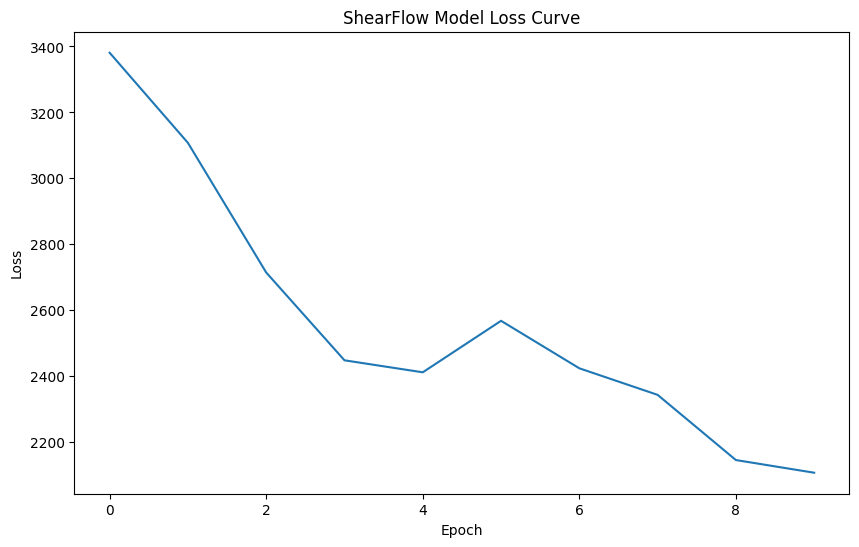

In [12]:
import pickle
import matplotlib.pyplot as plt
 
with open( "/home/wkt7ne/PARCtorch/PARCtorch/demos/results/SF_model_weights/training_losses.pkl", 'rb' ) as f: 
    history = pickle.load(f)
plt.figure(figsize=(10,6))
plt.title('ShearFlow Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(  history)
plt.savefig('normalization_loss_curve.png')
 